** 1.** **Importing and Loading Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**2. Loading and Understanding the Data**

In [2]:
df=pd.read_excel(r'/content/Snitch.xlsx')
df.head()
df.info()
df.dtypes
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 1 columns):
 #   Column                                      Non-Null Count  Dtype 
---  ------                                      --------------  ----- 
 0   The goal is to analyze the upcoming trends  5 non-null      object
dtypes: object(1)
memory usage: 188.0+ bytes


(7, 1)

**3. Assumptions and Data Cleaning:**
To ensure consistency, column names were standardized. Missing values in feature columns were filled with "Unknown," and rows with missing or "Unknown" categories were excluded from the analysis. A new column, TOTAL_SALES, was created by summing across all monthly columns, which were assumed to represent monthly sales figures.

In [3]:
# Standardizing column names
df.columns = df.columns.str.strip().str.upper().str.replace(" ", "_")


# In print_design column i have 1292 null values and i am removing rows because except category and color feature all row has
# NaN values and 0 in all months from 1 to 12.
df[df['PRINT_DESIGN'].isna()]
df[df['PRINT_DESIGN'].isna()].index
df.drop(labels=df[df['PRINT_DESIGN'].isna()].index,inplace=True,errors='ignore')

# In sleeve_type column we have NaN,i have filled with Unknown rather than deleting
df['SLEEVE_TYPE'].fillna('Unknown',inplace=True)

# in category column i have 1 NaN, i have deleted because it will not affect any rows because Month 1 to 12 all are 0.
df[df['CATEGORY'].isna()].index
df.drop(labels=df[df['CATEGORY'].isna()].index,inplace=True,errors='ignore')

# Checking FIT Column as it has 4 NaN. Deleting 4 rows as many features has NaN values and also Month 1 to Month 12 all are 0.
df[df['FIT'].isna()].index
df.drop(labels=df[df['FIT'].isna()].index,inplace=True,errors='ignore')

# Now Closure and Style column has only NaN, i am filling with Unknown in place of NaN so that data might not looks messy
df.fillna({'CLOSURE':'Unknown','STYLE':'Unknown'},inplace=True)

# Creating TOTAL_SALES column
month_cols = [col for col in df.columns if col.startswith('MONTH')]
df['TOTAL_SALES'] = df[month_cols].sum(axis=1)

# Creating a feature column
feature_columns = ['FIT', 'MATERIAL_NEW', 'PRINT_DESIGN', 'SLEEVE_TYPE', 'COLLAR_NEW','OCCASSION_NEW','COLOR']

KeyError: 'PRINT_DESIGN'

**Q1. For each category, show which feature is most influential (highest total sales by feature value)**

**Approach ->** For each product category, I evaluated all specified features to determine which individual feature values contributed the highest total sales. This allowed me to quantify the influence of each feature on overall sales performance. The results were then sorted and visualized using bar charts to highlight the top-performing features within each category.

Available categories:
Shirts                  8450
T-Shirts                1485
Jeans                   1308
Trousers                1057
Overshirt                495
Cargo Pants              429
Jackets                  246
Sweaters                 138
Joggers & Trackpants     107
Sweatshirts               77
Pyjamas                   43
Name: CATEGORY, dtype: int64

Category: T-Shirts, Rows: 1485


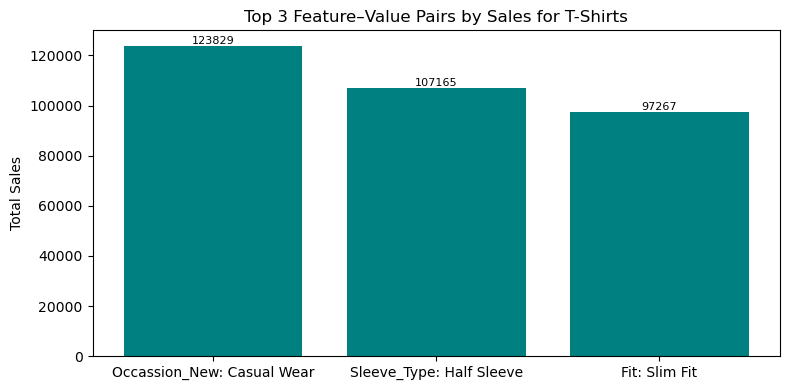


Category: Jeans, Rows: 1308


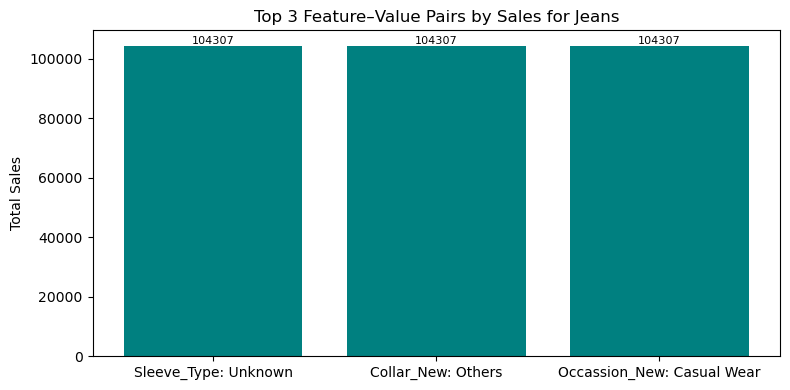


Category: Shirts, Rows: 8450


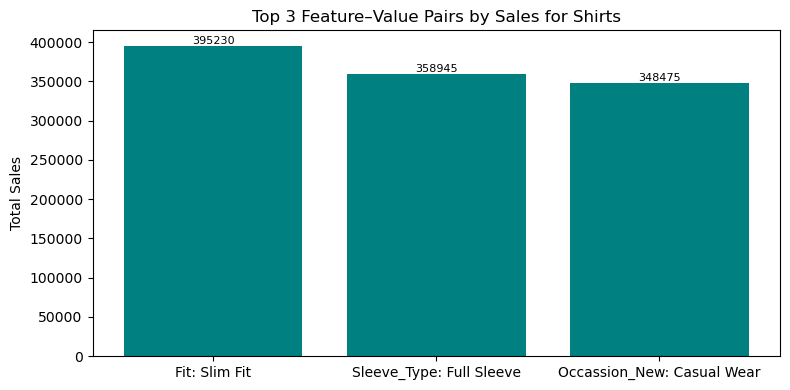


Category: Cargo Pants, Rows: 429


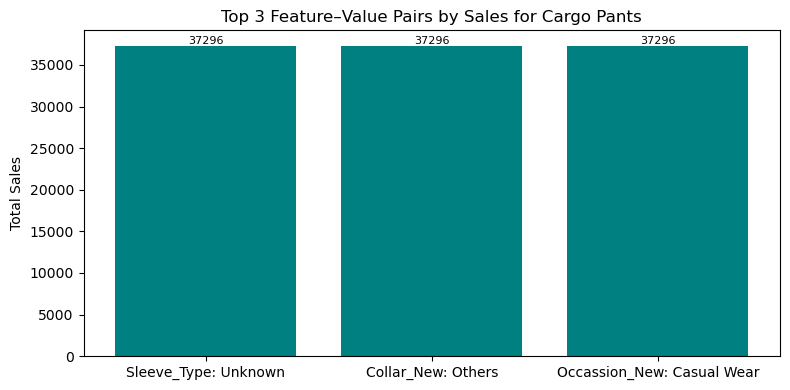


Category: Overshirt, Rows: 495


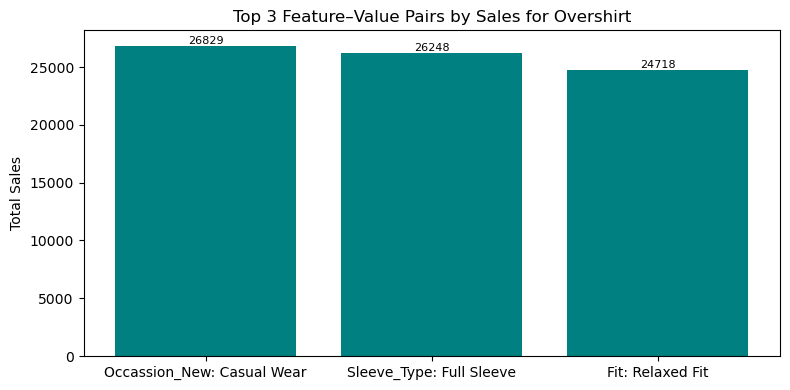


Category: Trousers, Rows: 1057


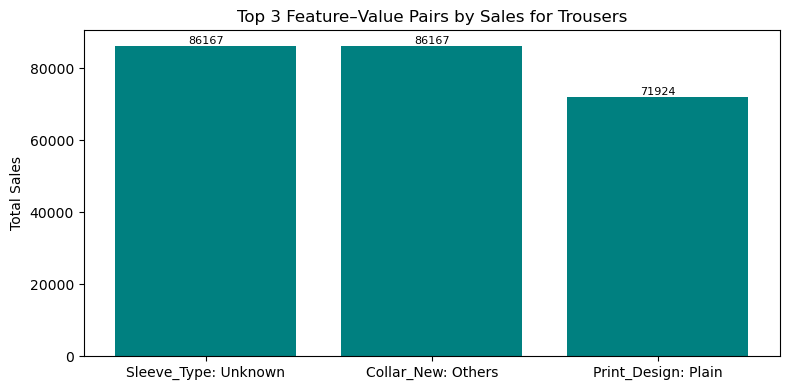


Category: Sweaters, Rows: 138


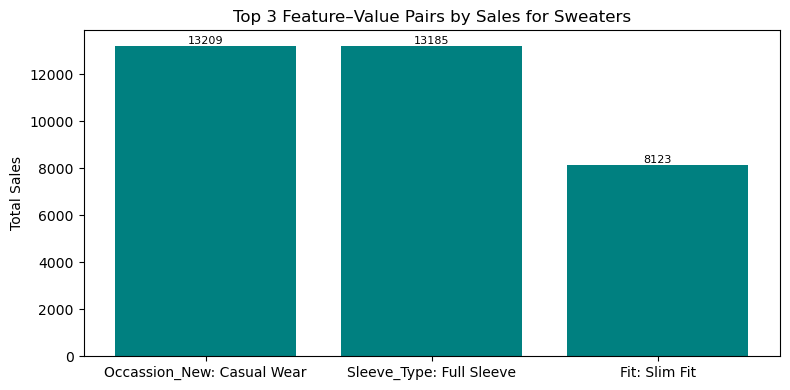


Category: Jackets, Rows: 246


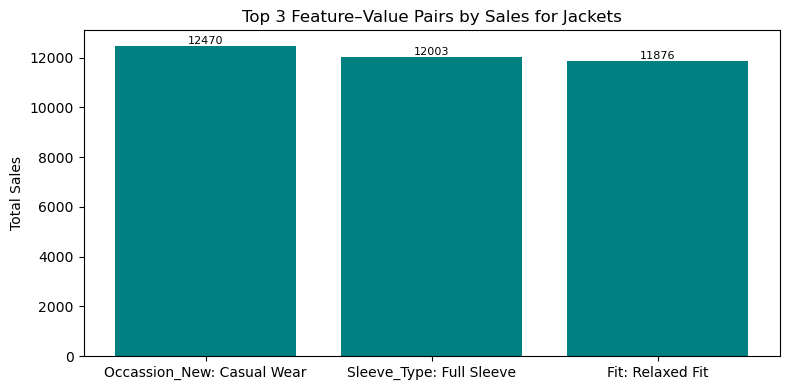


Category: Pyjamas, Rows: 43


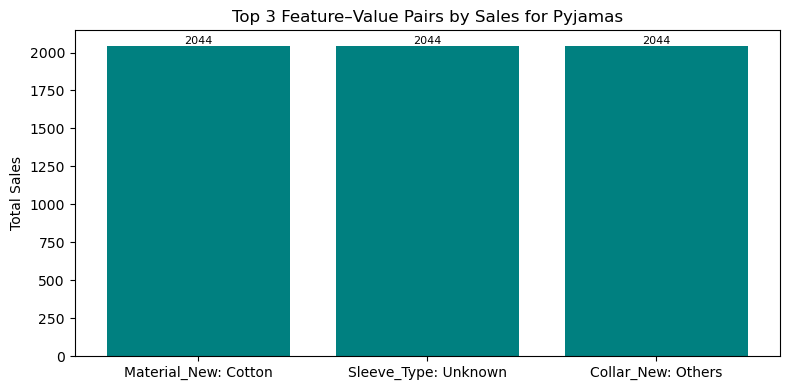


Category: Sweatshirts, Rows: 77


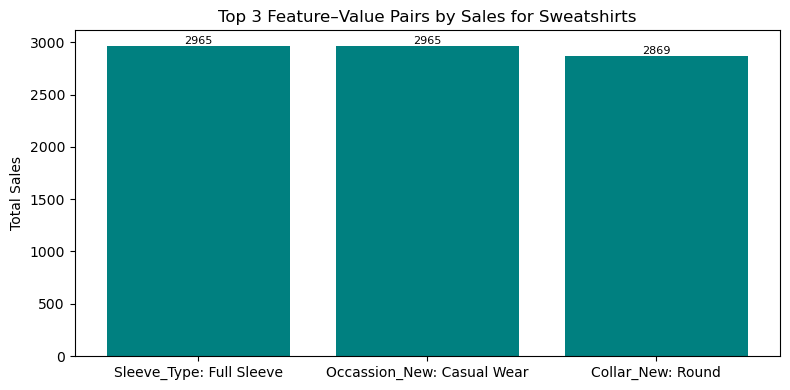


Category: Joggers & Trackpants, Rows: 107


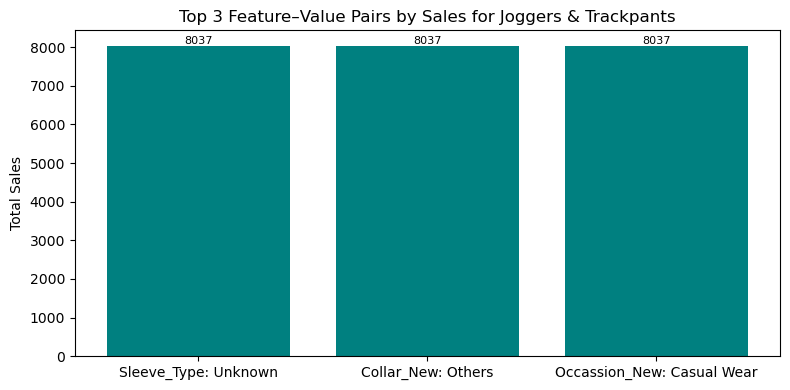

In [ ]:
# Print available categories
print("Available categories:")
print(df['CATEGORY'].value_counts())

# Plot top 3 (feature, value) pairs per category by total sales
for category in df['CATEGORY'].unique():
    cat_df = df[df['CATEGORY'] == category]
    print(f"\nCategory: {category}, Rows: {cat_df.shape[0]}")

    value_sales = []
    for feature in feature_columns:
        if feature in cat_df.columns:
            sales_by_value = cat_df.groupby(feature)['TOTAL_SALES'].sum()
            for value, total in sales_by_value.items():
                label = f"{feature.title()}: {value}"
                value_sales.append((label, total))

    # Sort and take top 3 feature-value pairs
    top3 = sorted(value_sales, key=lambda x: x[1], reverse=True)[:3]
    labels = [x[0] for x in top3]
    sales = [x[1] for x in top3]

    # Plot
    plt.figure(figsize=(8, 4))
    bars = plt.bar(labels, sales, color='teal')
    plt.title(f'Top 3 Feature–Value Pairs by Sales for {category}')
    plt.ylabel('Total Sales')

    # Annotate bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{int(yval)}', ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.show()


**Q2. What are the upcoming trends on the basis of features Category Wise.**

**Approach ->** The dataset was reshaped into a long format to facilitate time-series analysis of monthly sales. For each combination of category and feature, I computed the average monthly growth rate (slope) in sales. Based on these calculations, the top three feature values exhibiting the highest positive growth were identified as indicators of emerging trends. Their sales trajectories were then visualized using line charts to clearly highlight these evolving patterns.

**Note:**
In some cases, only a single graph is displayed because the data for certain category-feature combinations may not contain enough distinct feature values with meaningful monthly growth. The analysis computes growth trends based on the average change in sales over time (slope). If fewer than three feature values show positive or non-zero growth, only those available values are plotted. If all growth values are zero or insufficient data exists, the plot is skipped altogether to maintain the clarity and relevance of the visual output.

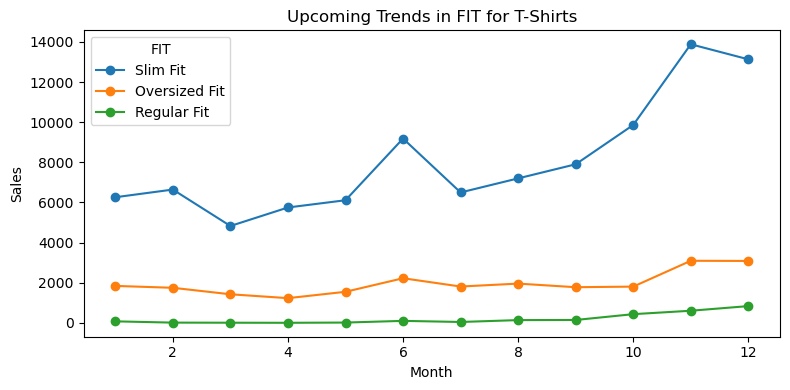

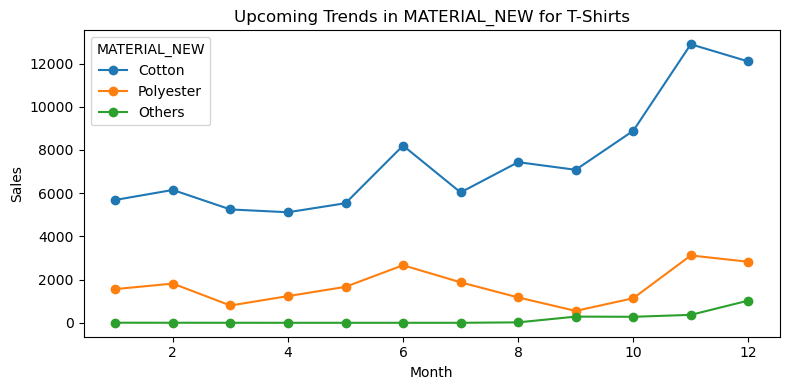

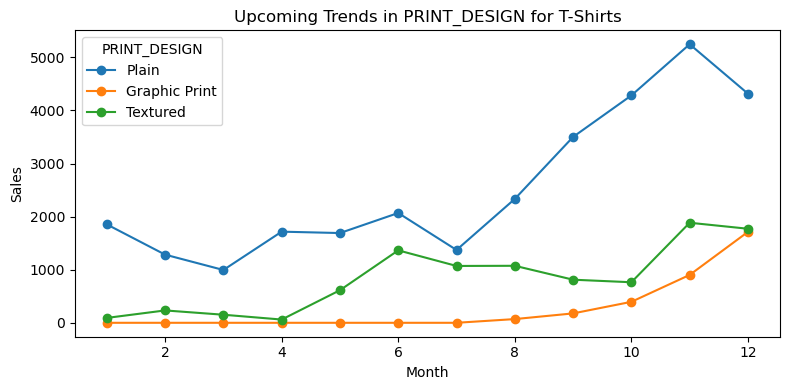

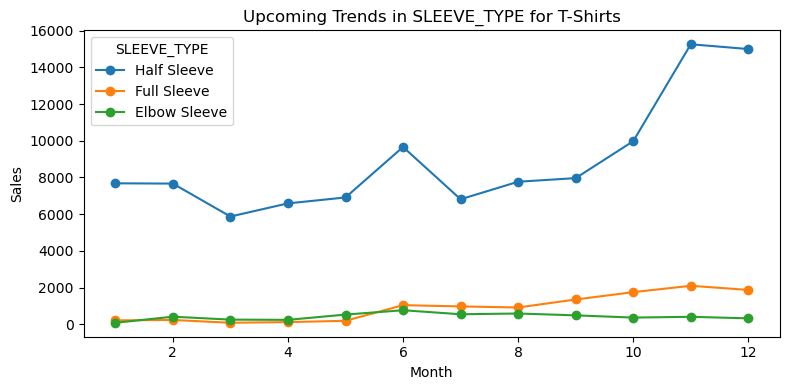

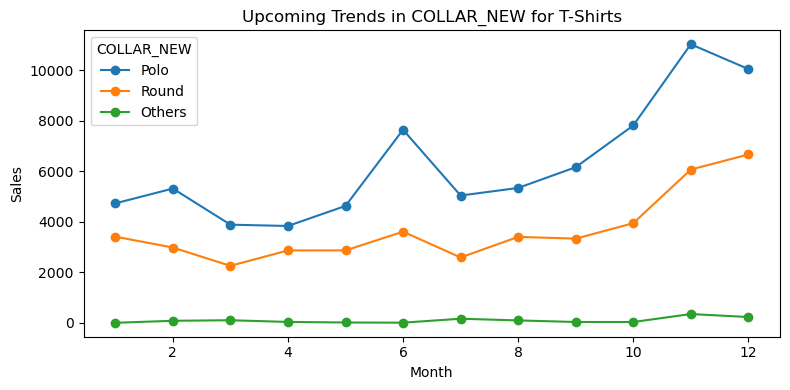

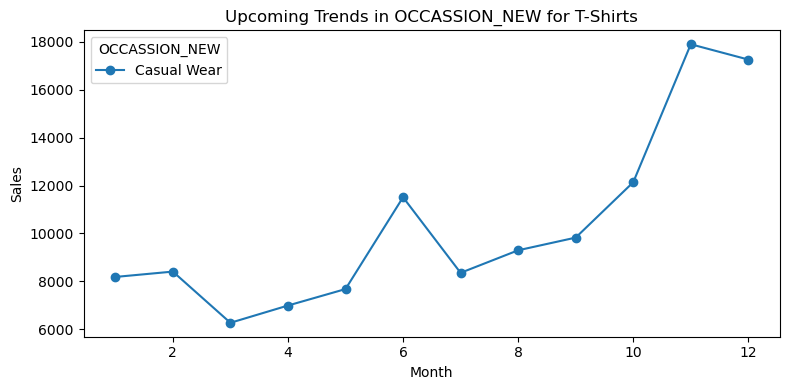

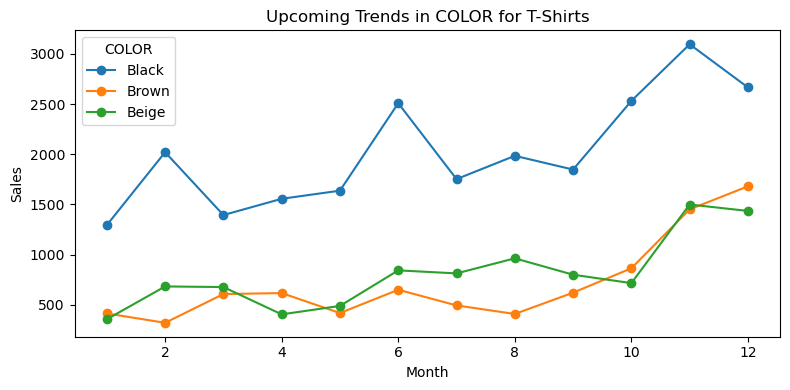

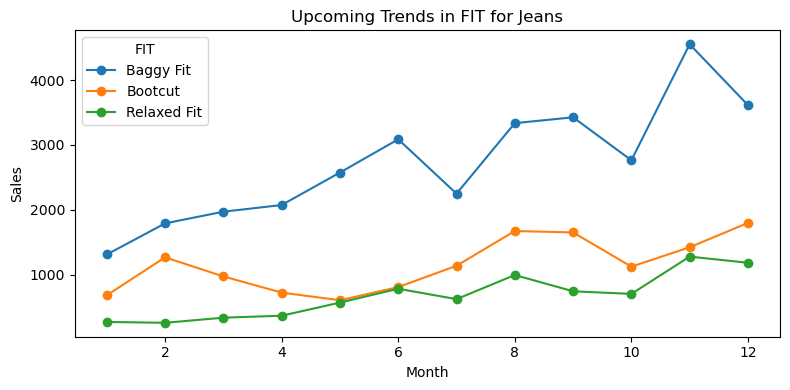

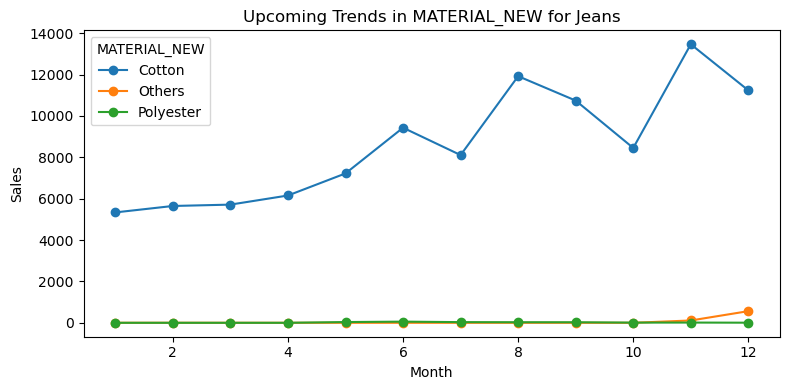

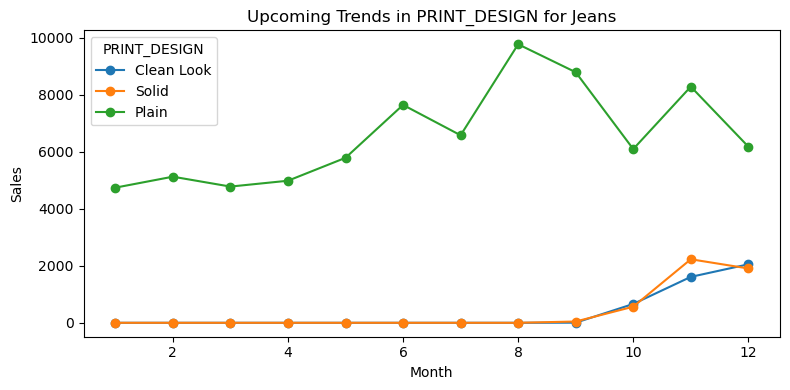

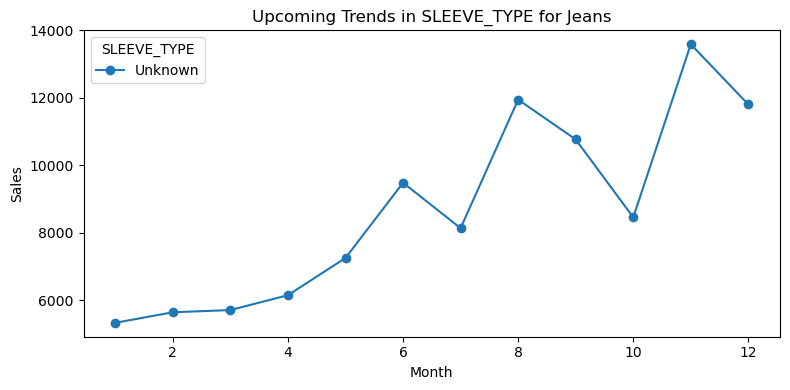

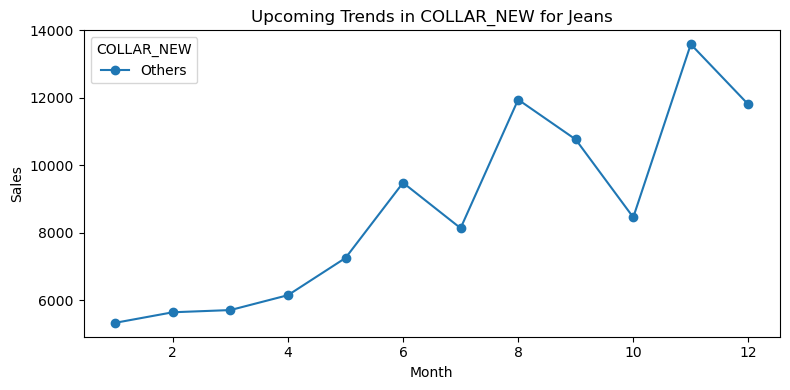

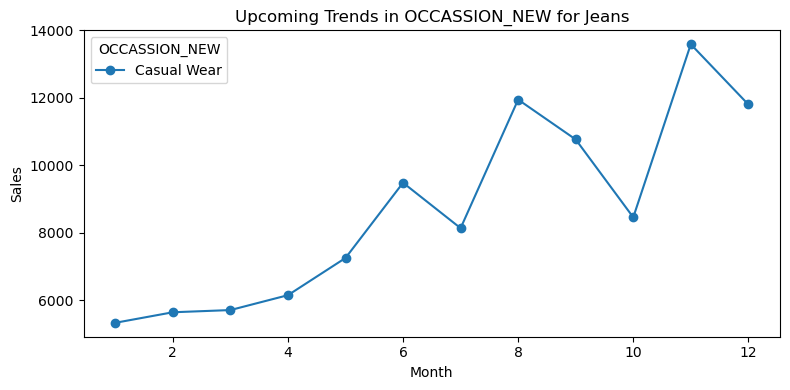

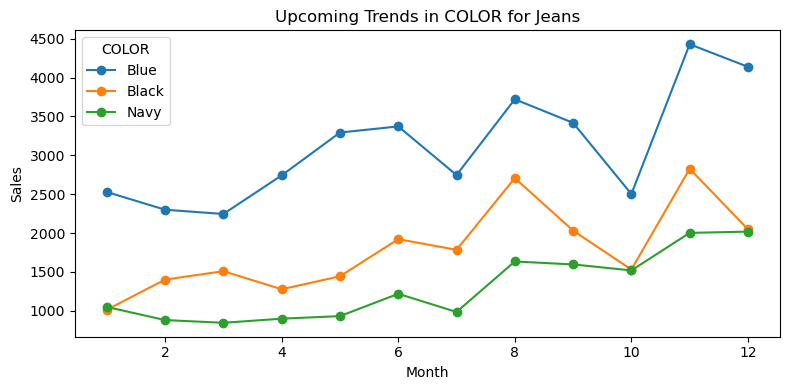

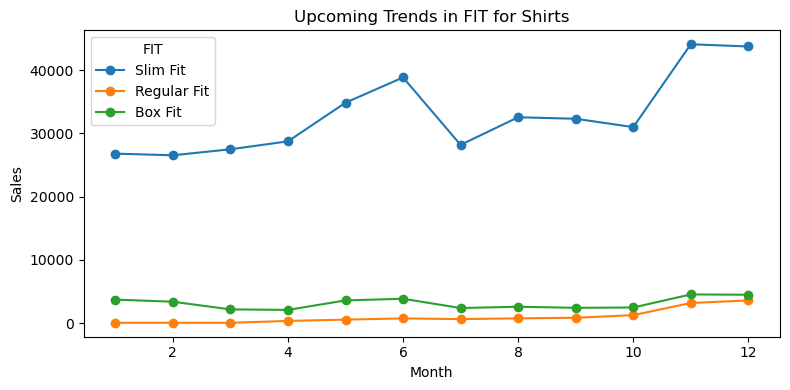

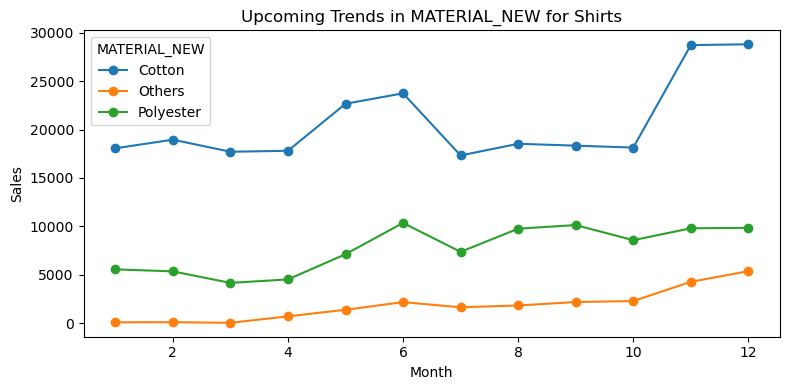

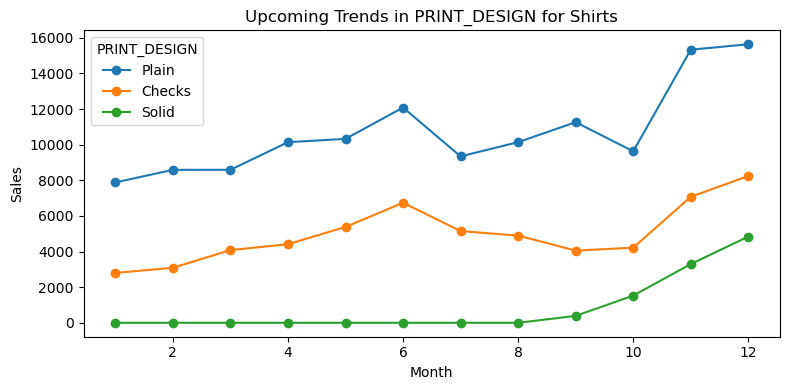

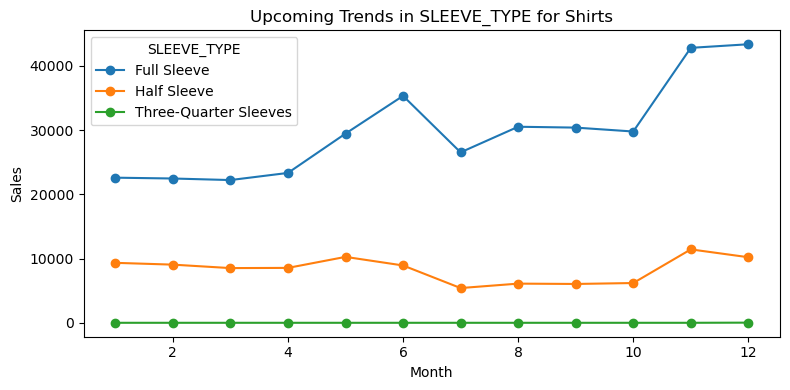

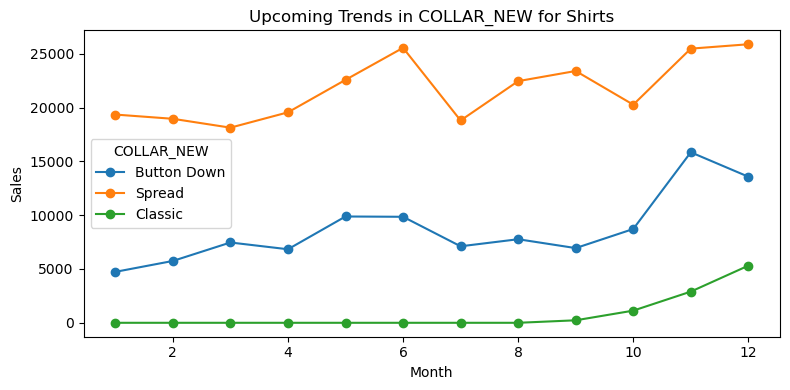

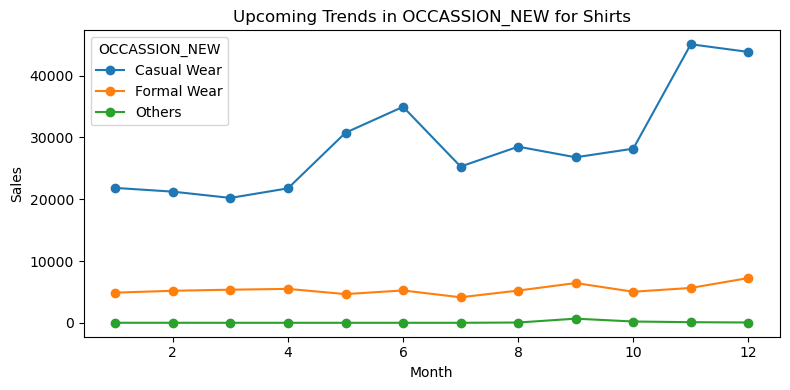

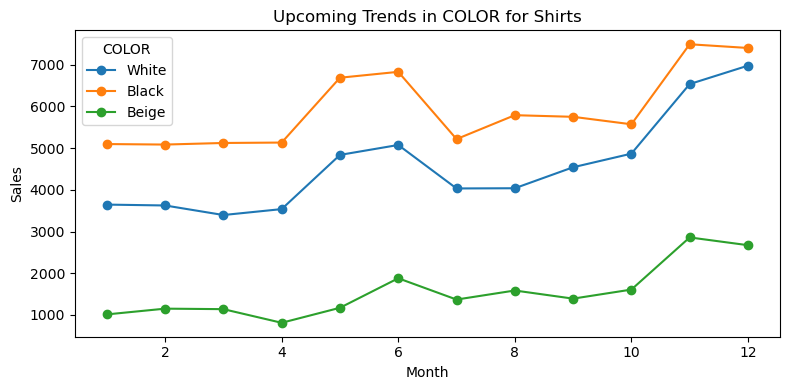

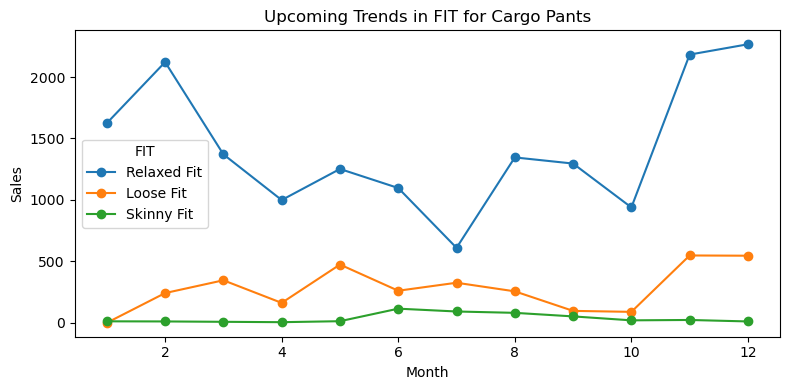

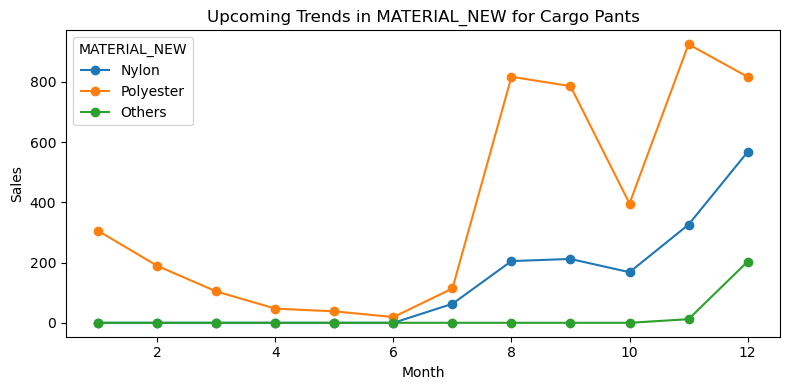

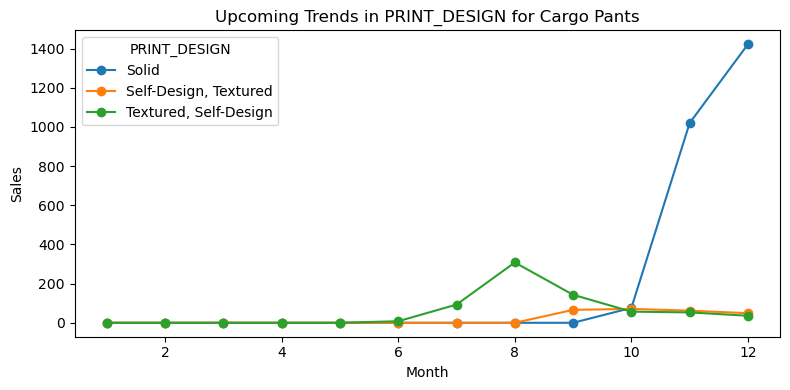

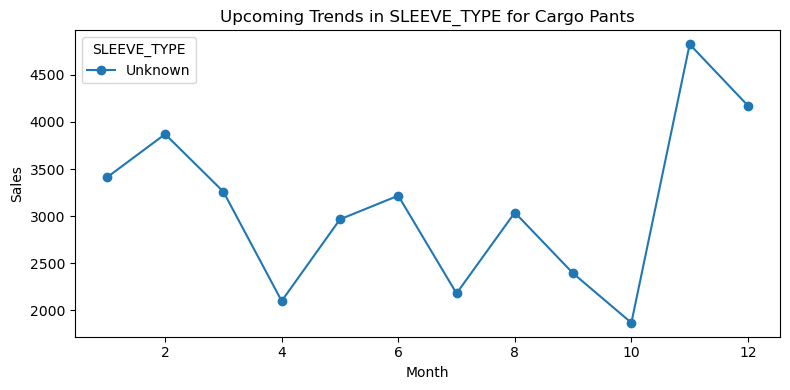

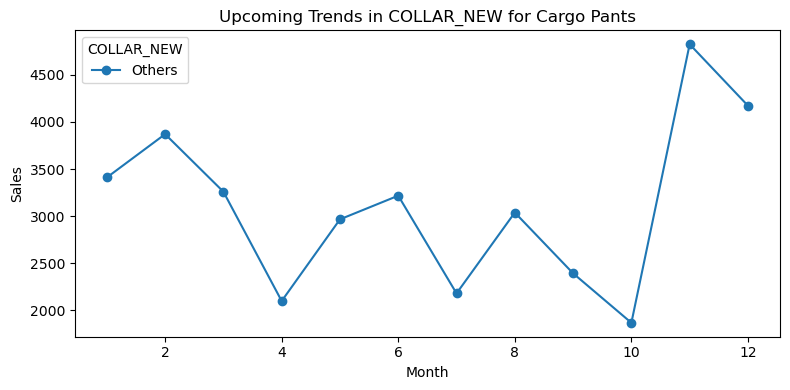

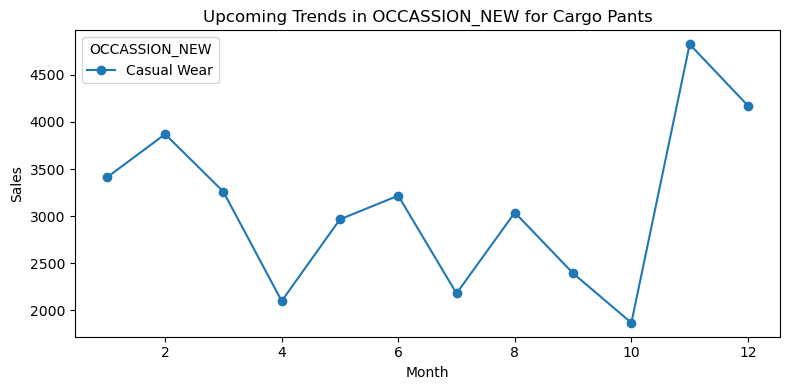

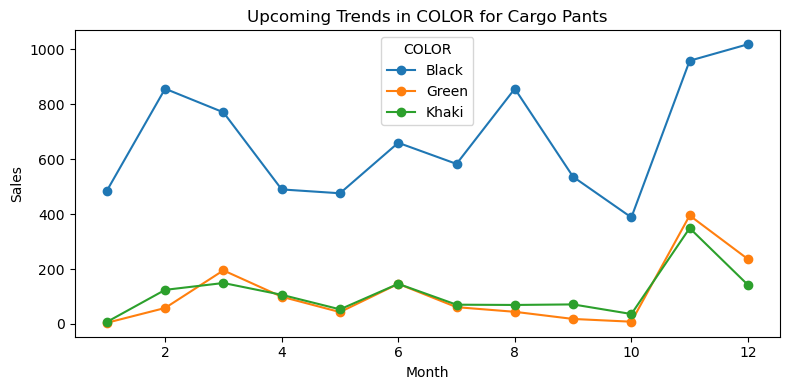

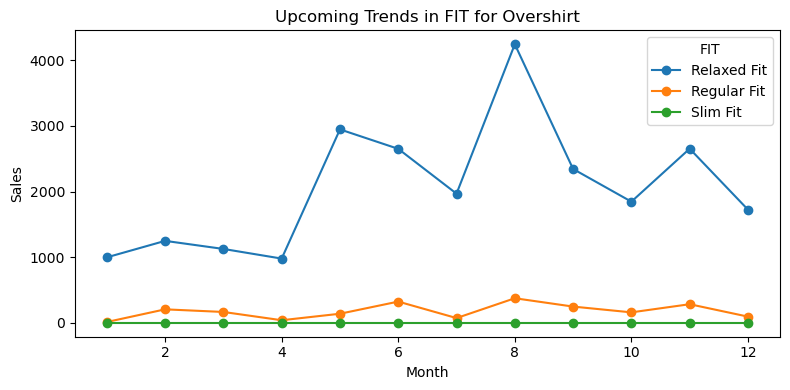

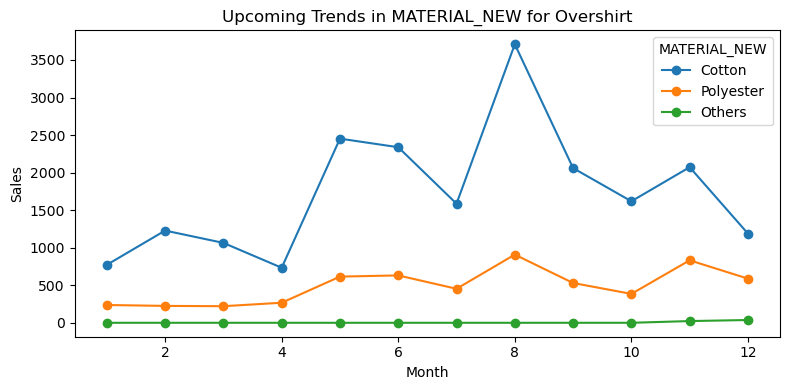

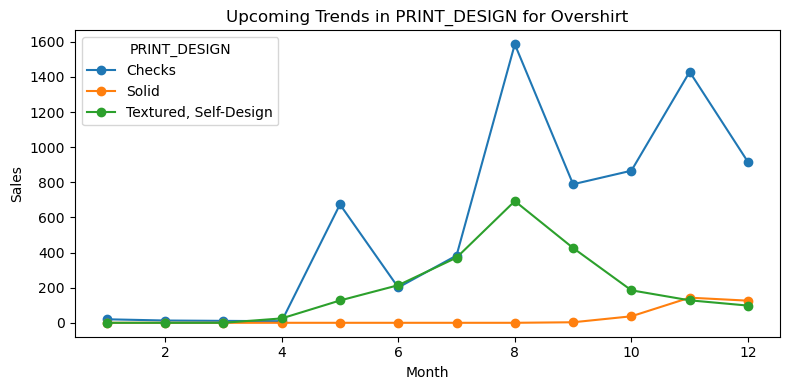

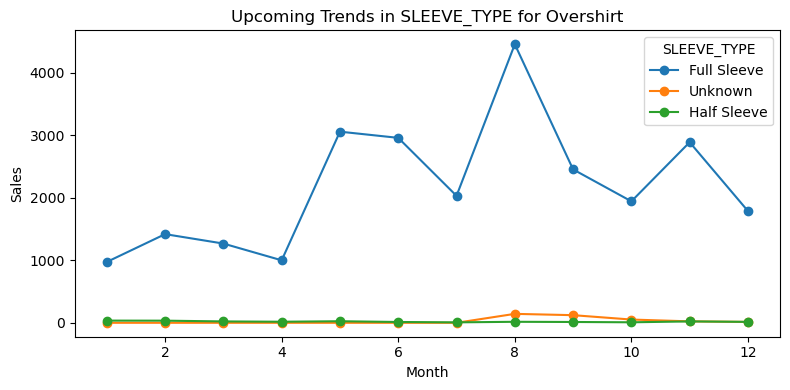

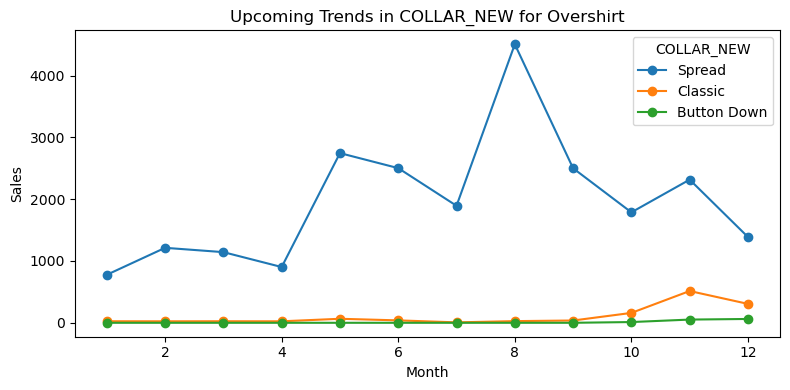

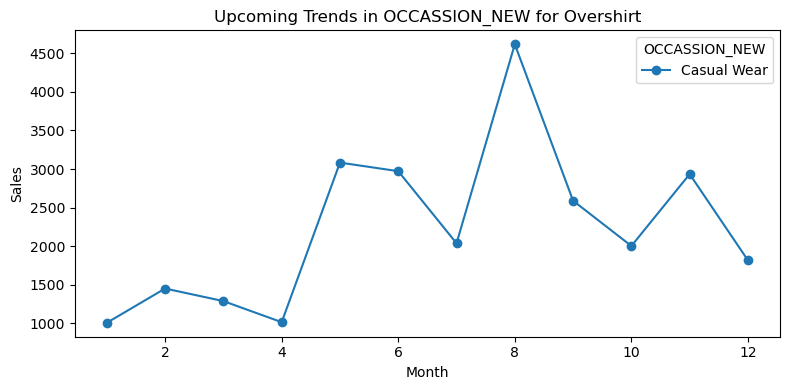

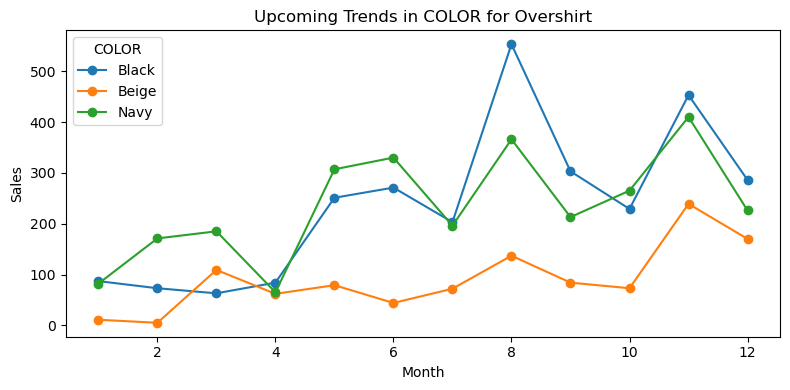

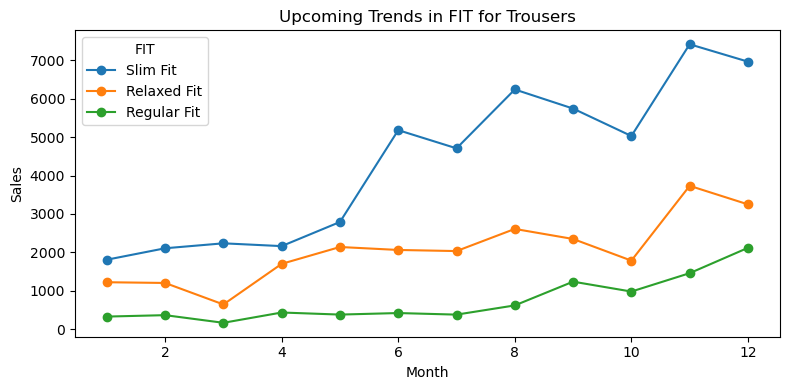

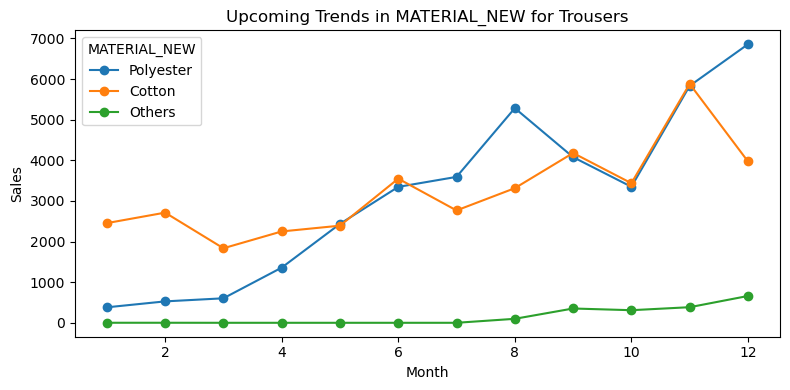

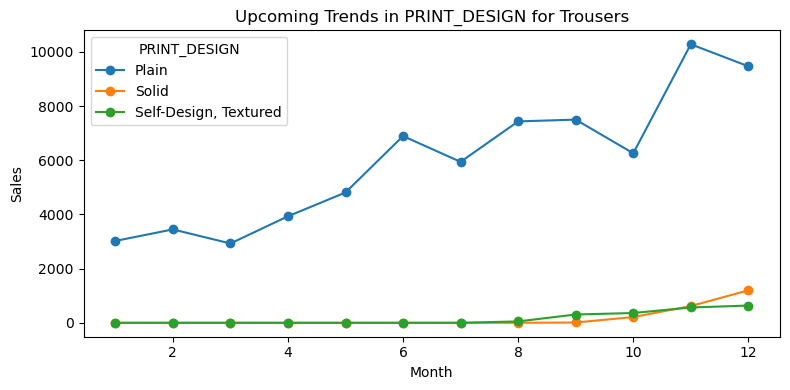

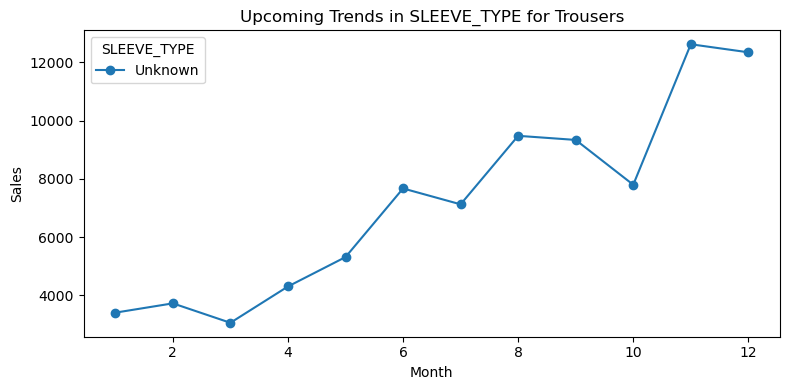

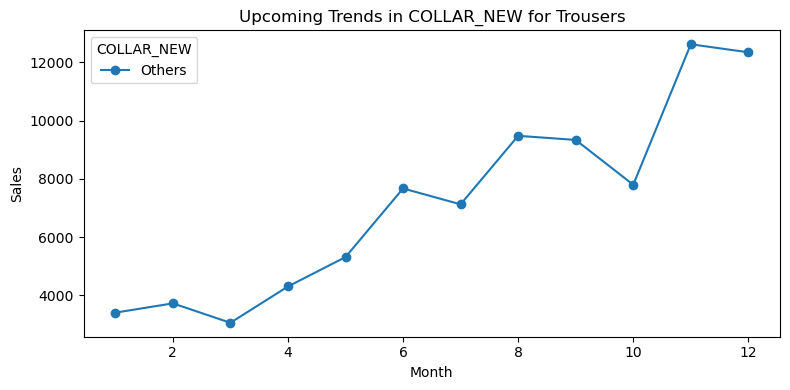

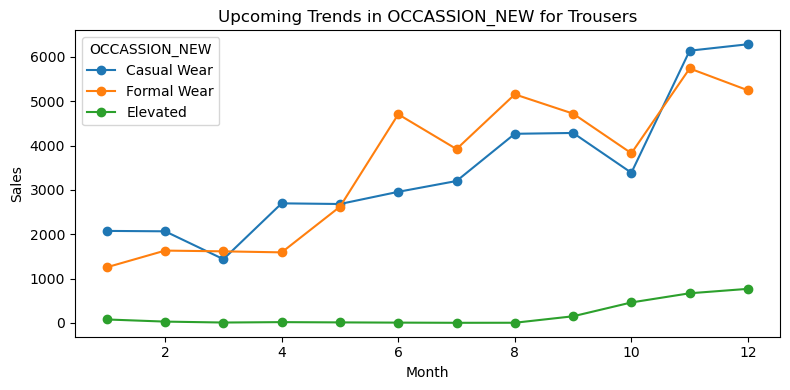

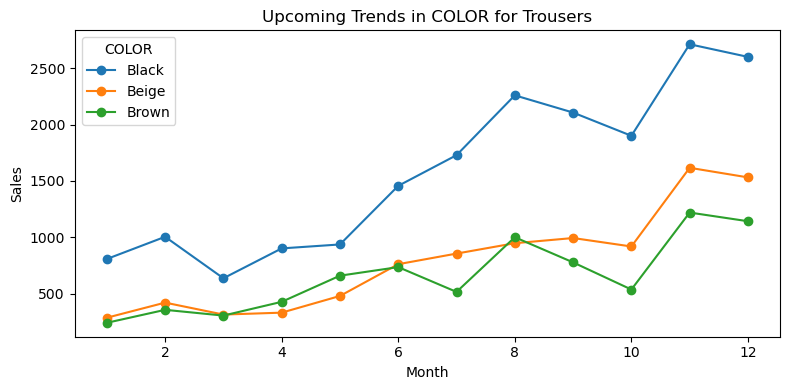

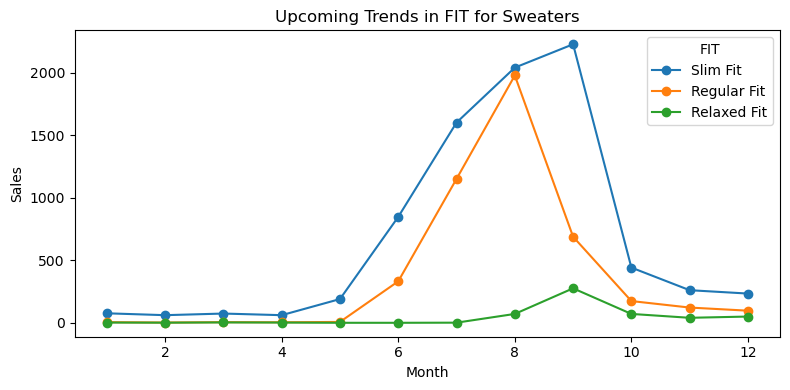

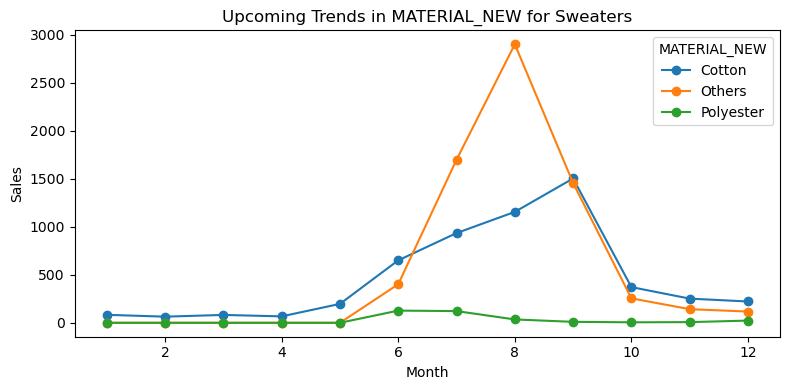

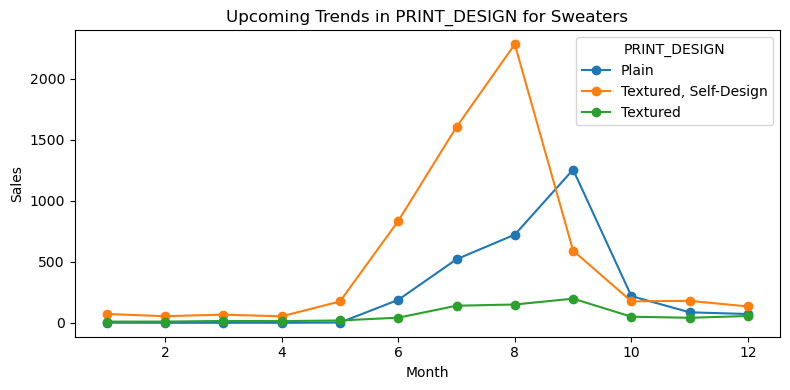

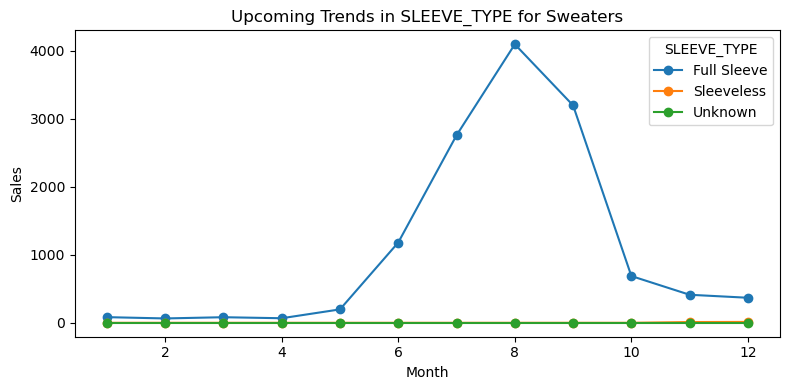

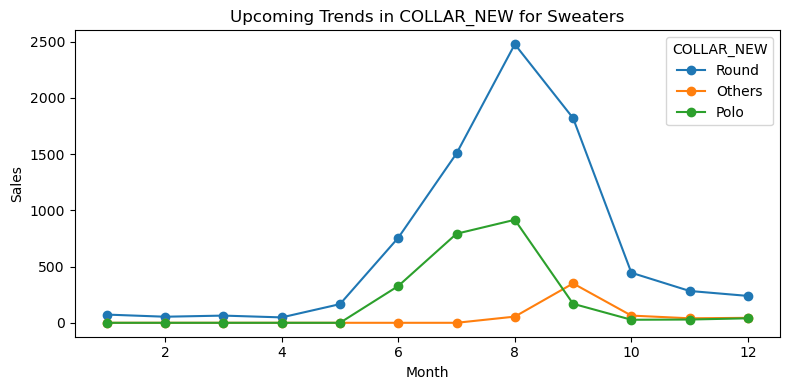

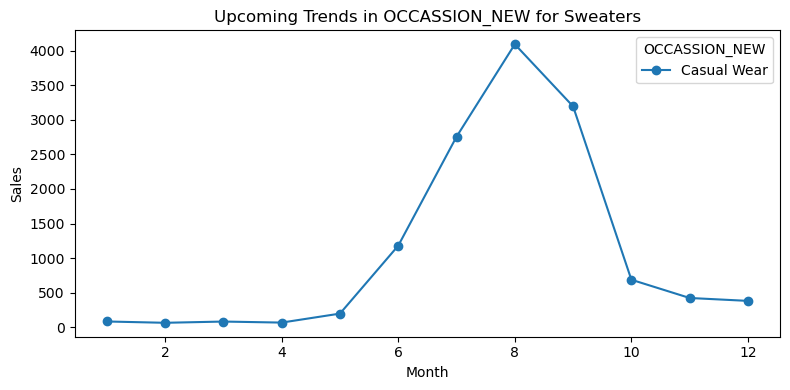

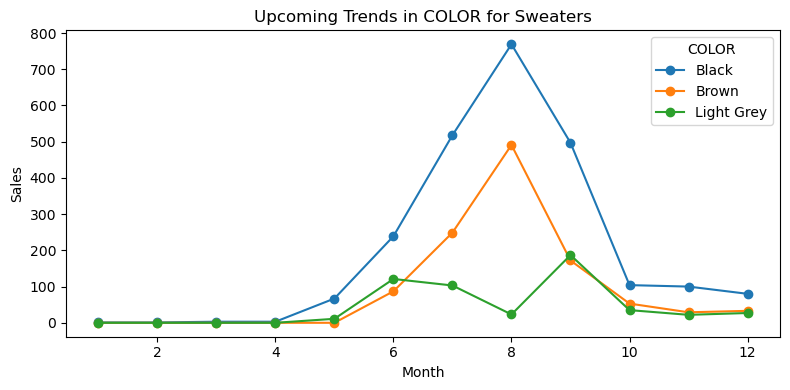

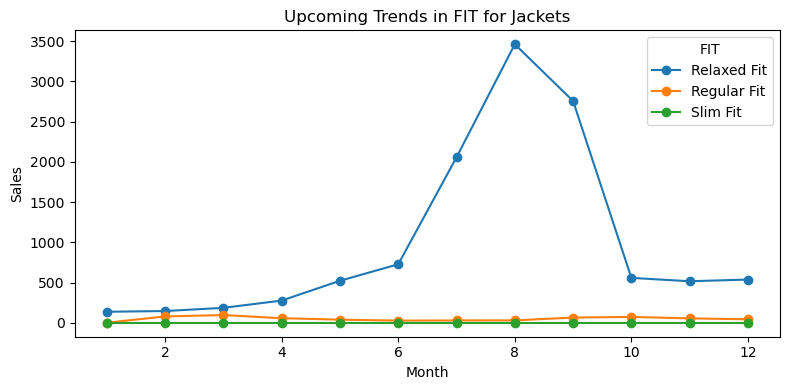

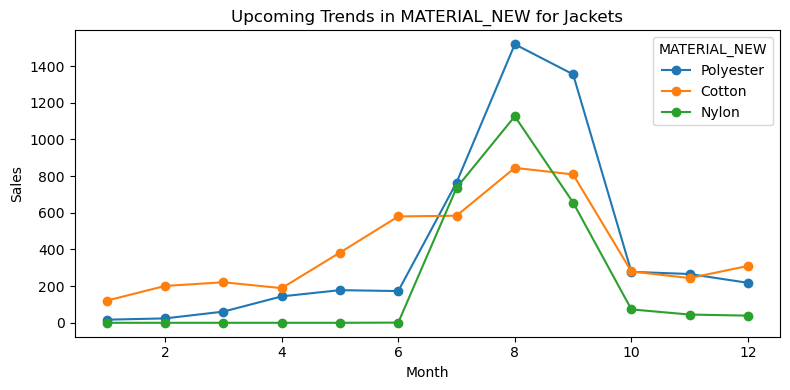

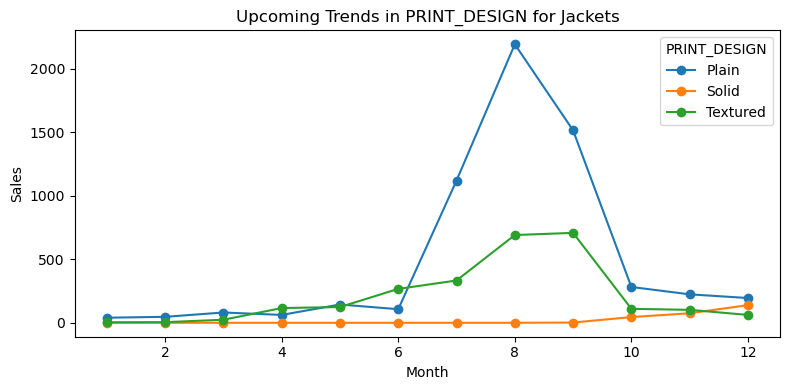

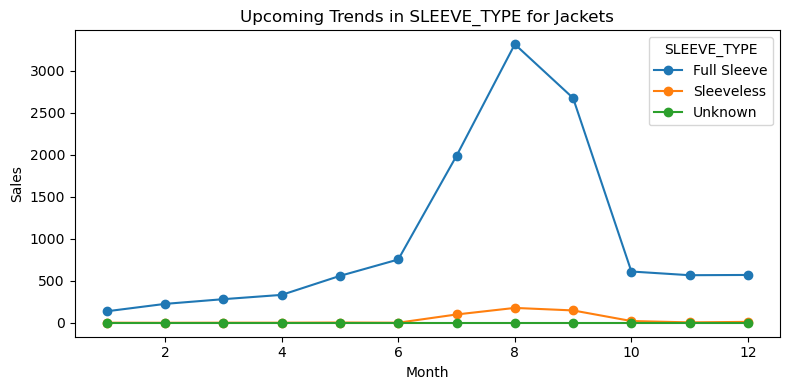

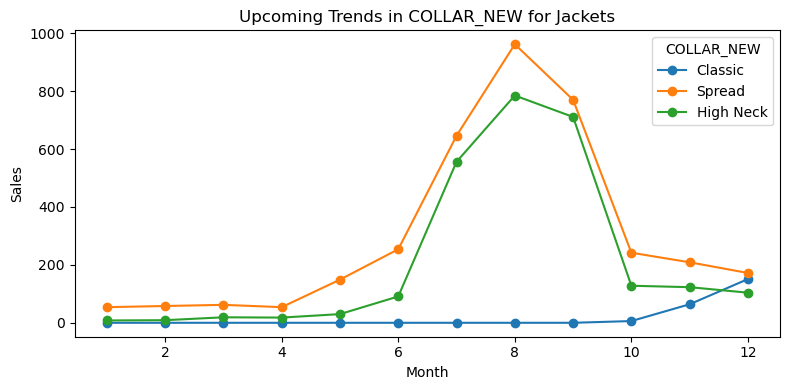

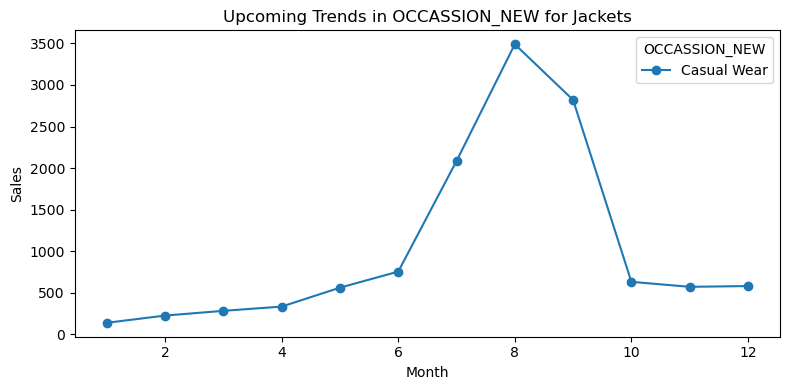

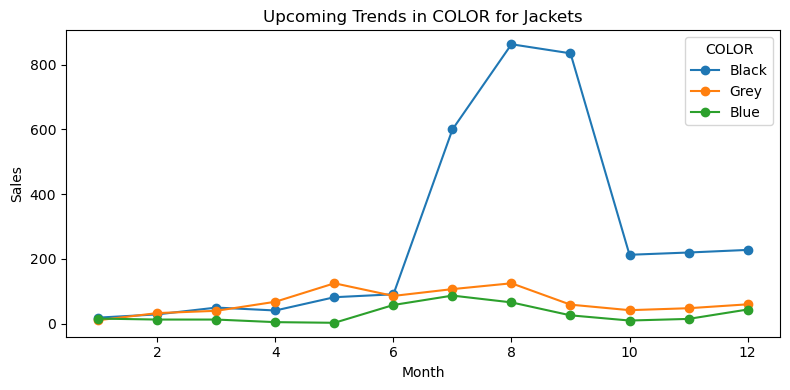

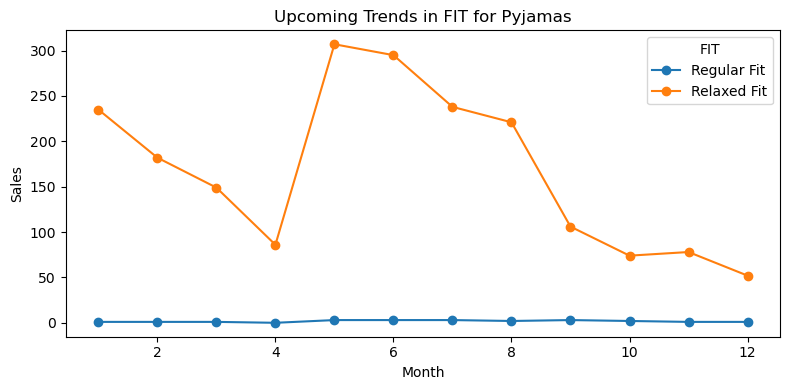

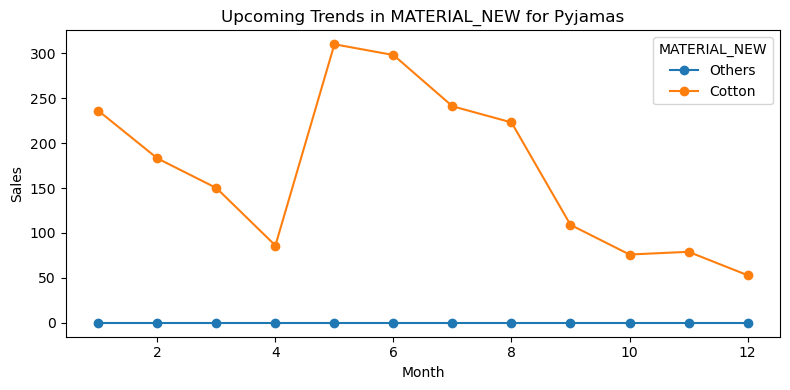

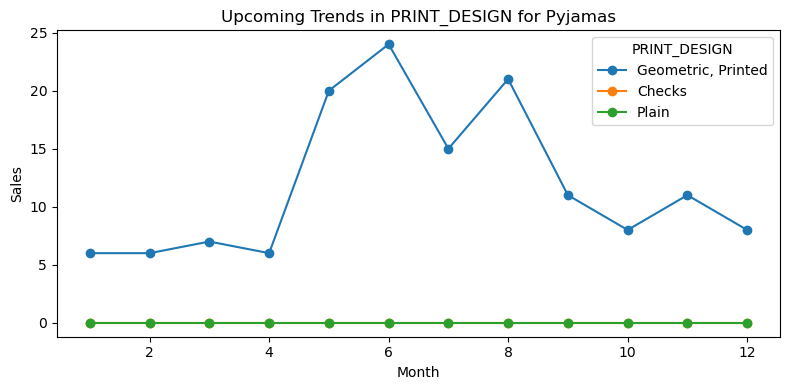

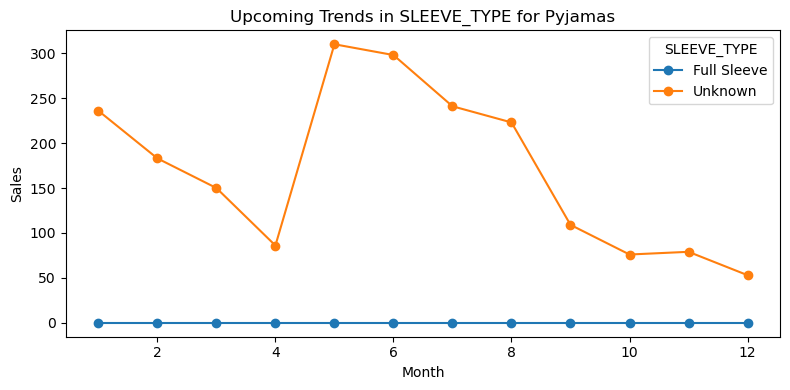

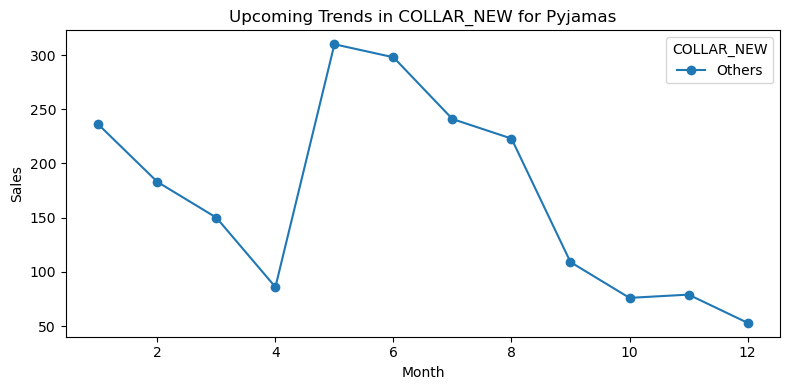

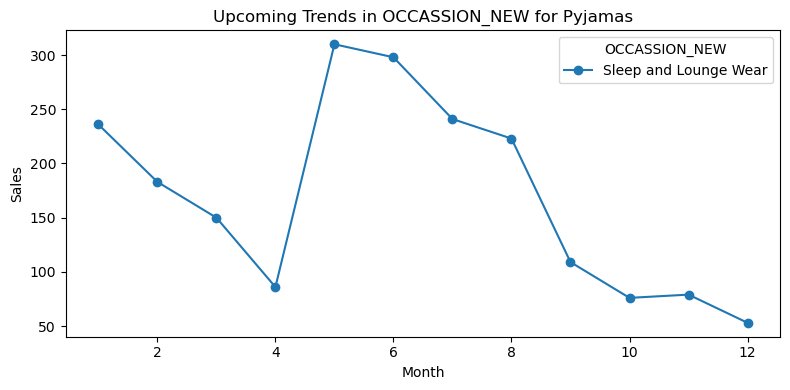

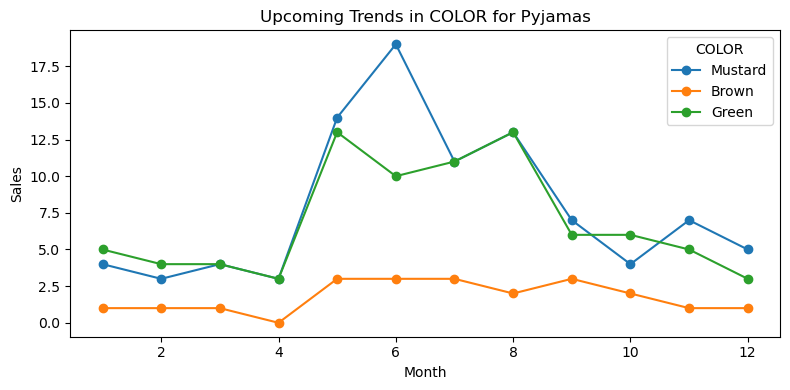

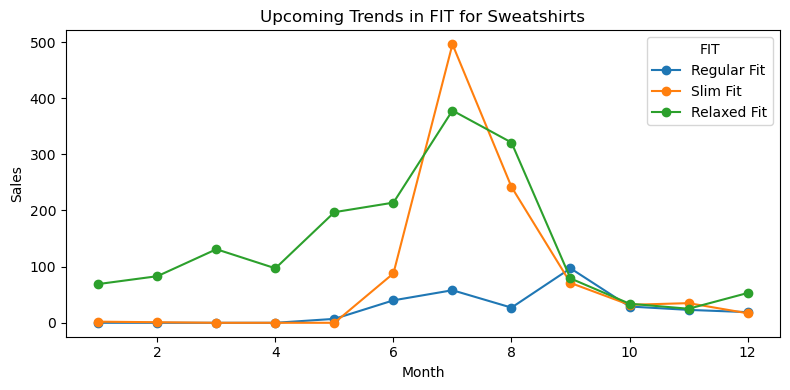

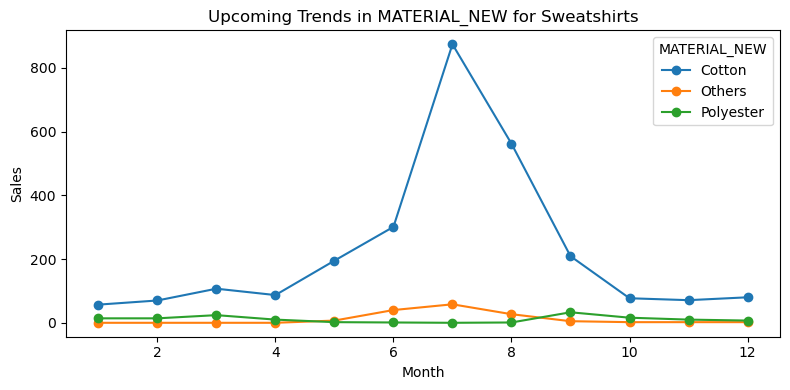

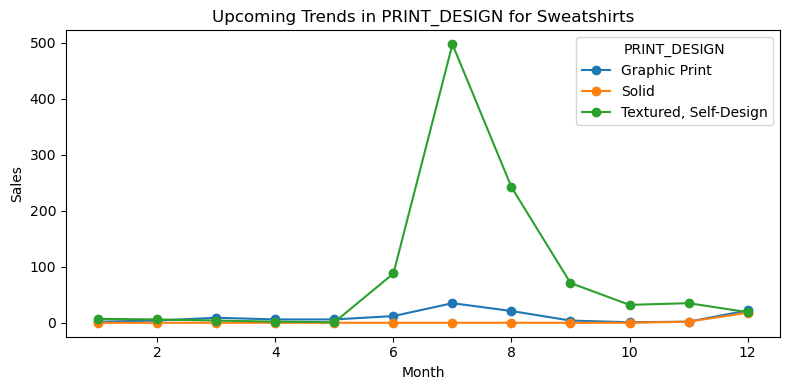

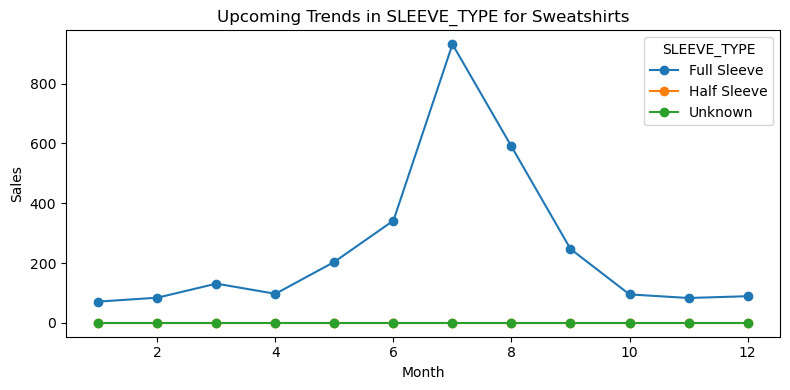

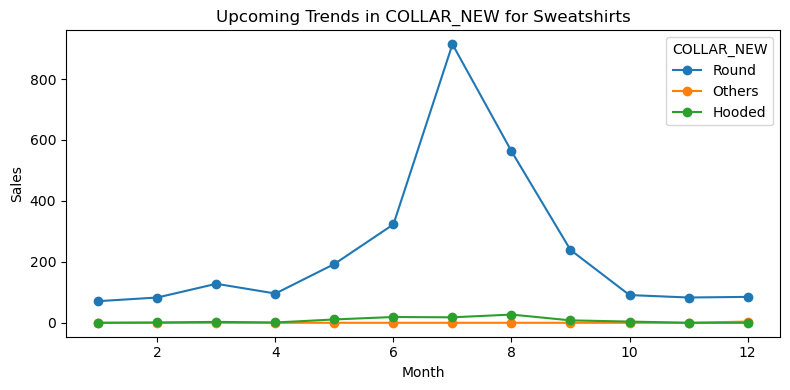

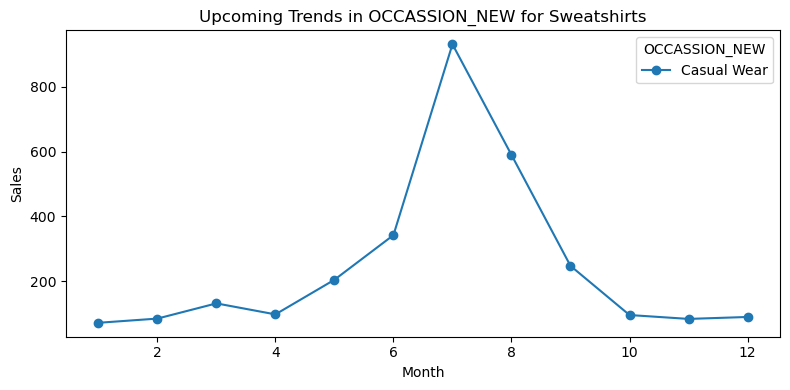

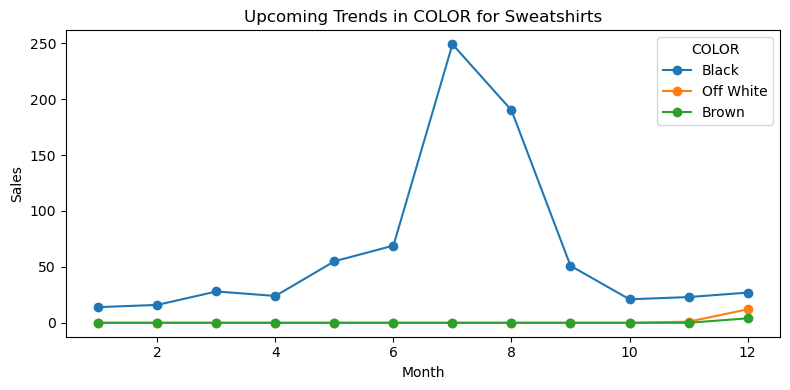

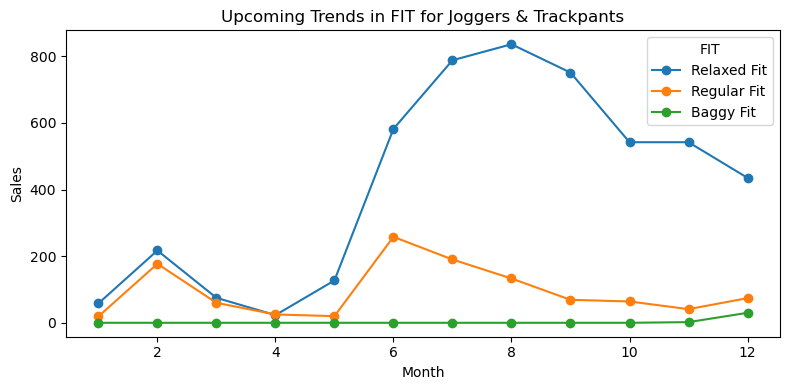

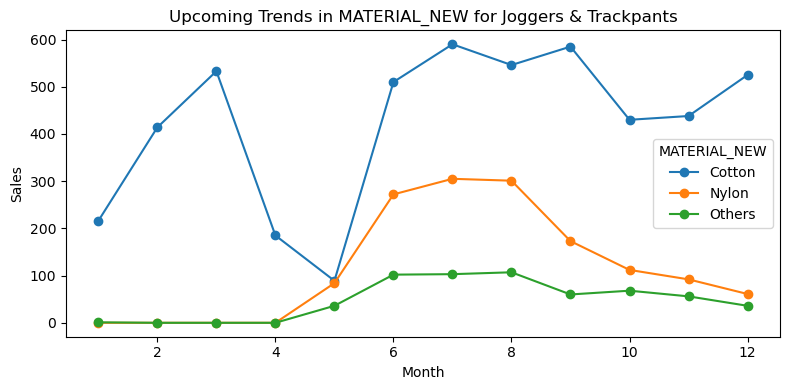

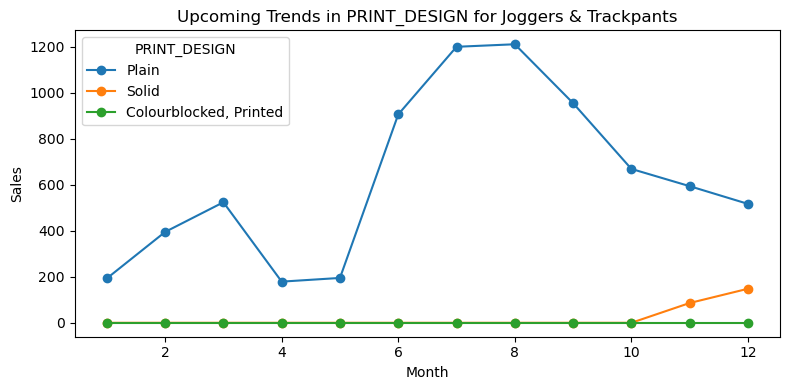

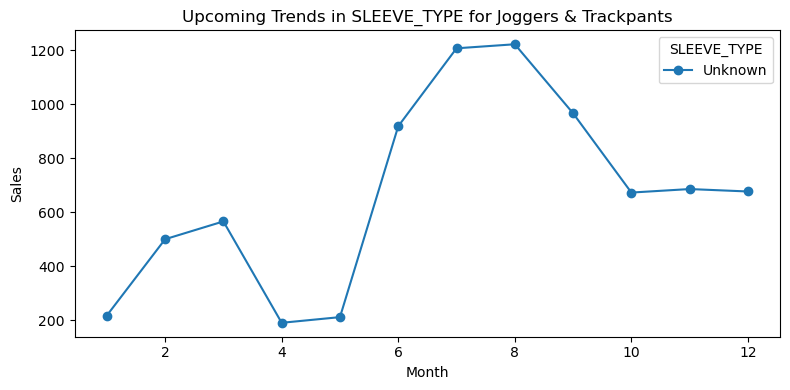

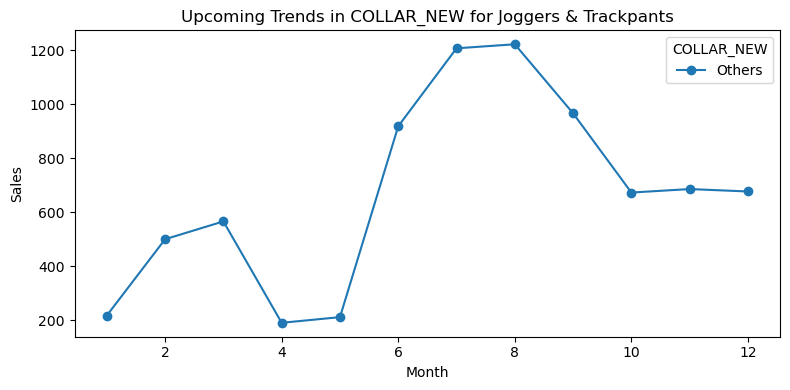

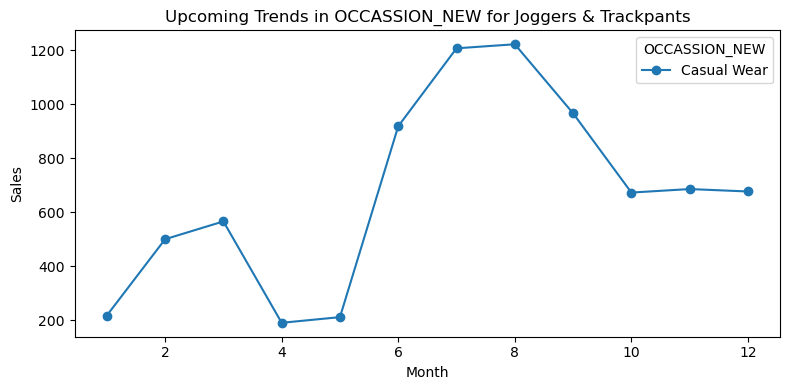

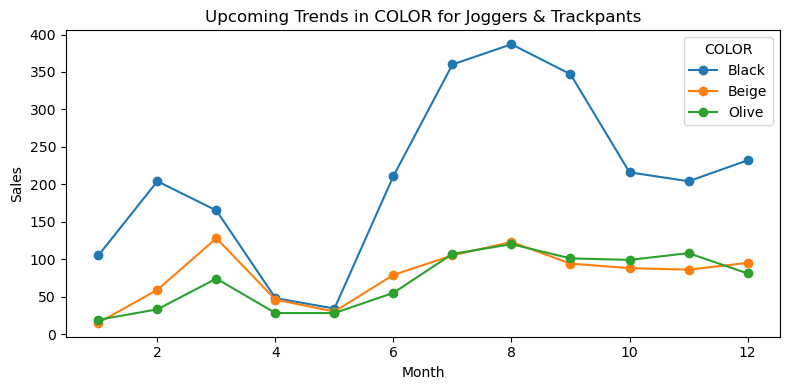

In [ ]:
# Melt to long format for time series
df_long = df.melt(
    id_vars=['CATEGORY'] + feature_columns,
    value_vars=month_cols,
    var_name='MONTH',
    value_name='SALES'
)
df_long['MONTH_NUM'] = df_long['MONTH'].str.extract('(\d+)').astype(int)

# For each category and feature, plotting top 3 growing feature values
for category in df_long['CATEGORY'].unique():
    cat_df = df_long[df_long['CATEGORY'] == category]
    for feature in feature_columns:
        # Get total sales per value per month
        pivot = cat_df.groupby([feature, 'MONTH_NUM'])['SALES'].sum().reset_index()
        # Calculating growth (slope) for each value
        growth = {}
        for val in pivot[feature].unique():
            sales_series = pivot[pivot[feature] == val].sort_values('MONTH_NUM')
            if len(sales_series) > 1:
                slope = pd.Series(sales_series['SALES'].values).diff().mean()
                growth[val] = slope
        # Get top 3 growing values
        top_vals = sorted(growth.items(), key=lambda x: x[1], reverse=True)[:3]
        if not top_vals or all(v[1] == 0 for v in top_vals):
            continue
        # Plot
        plt.figure(figsize=(8,4))
        for val, _ in top_vals:
            sales = pivot[pivot[feature] == val].sort_values('MONTH_NUM')
            plt.plot(sales['MONTH_NUM'], sales['SALES'], marker='o', label=val)
        plt.title(f"Upcoming Trends in {feature} for {category}")
        plt.xlabel('Month')
        plt.ylabel('Sales')
        plt.legend(title=feature)
        plt.tight_layout()
        plt.show()

**Q3. What are the trends that are vanishing with time.**

**Approach ->** The dataset was transformed into a long format to enable time-series analysis of monthly sales. For each combination of category and feature, I analyzed the trend in sales over time by computing the slope of the best-fit line using np.polyfit. Feature values with the steepest negative slopes were identified as those exhibiting the sharpest decline in sales — indicating vanishing trends. The top three such values were selected and their sales trajectories were visualized to clearly illustrate the downward trend.

**Note:**
Some graphs display only one plot because the code filters for the top 3 feature values with the most negative sales slopes per category and feature. If fewer than three values have a negative slope (i.e., vanishing trend), or only one meets this condition, the plot will show only those available series, sometimes just one.

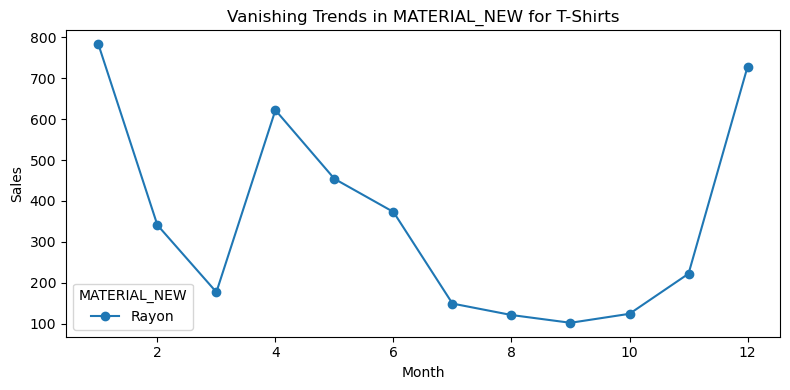

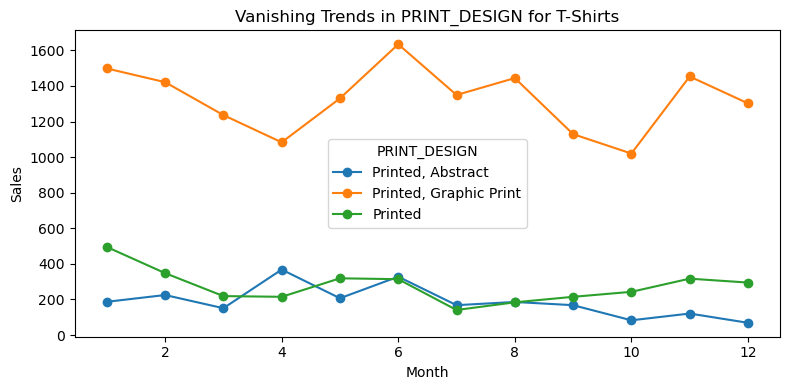

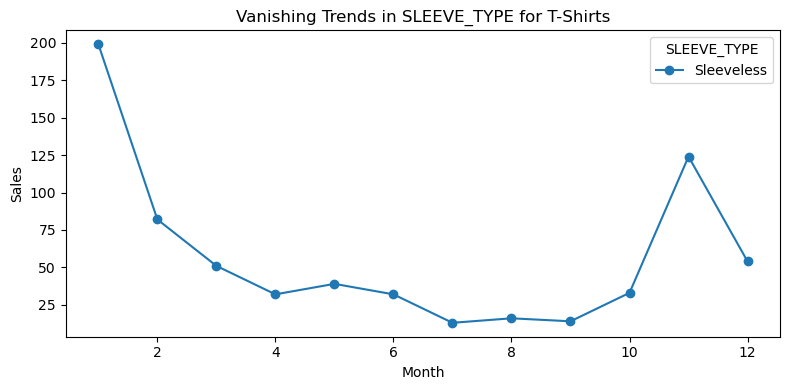

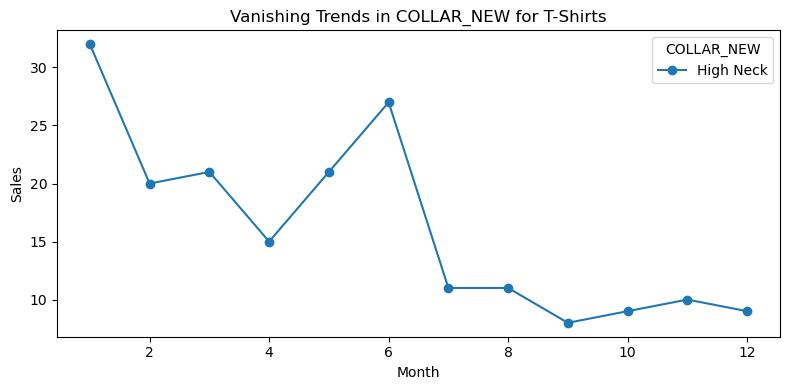

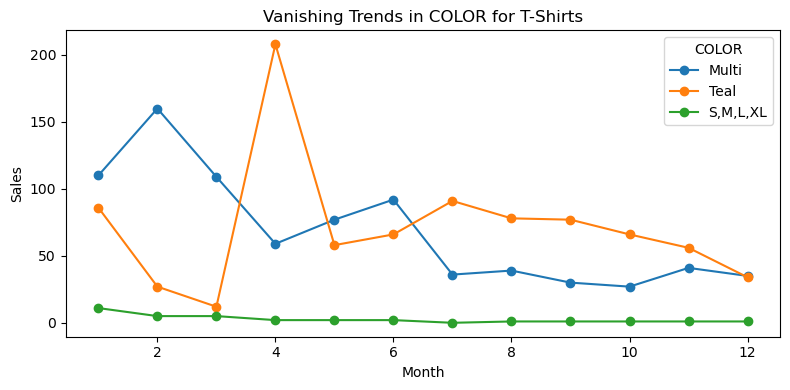

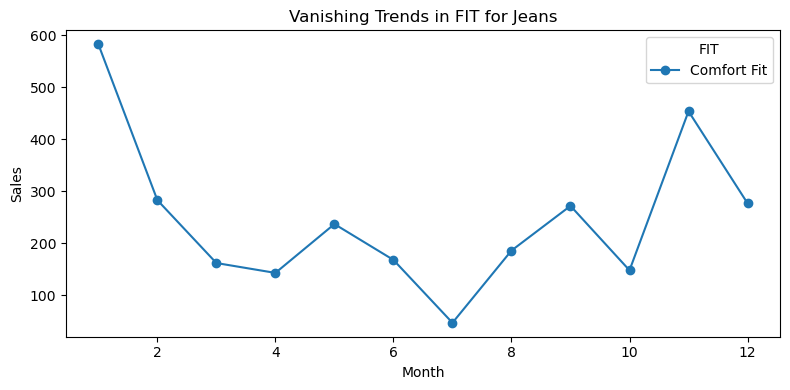

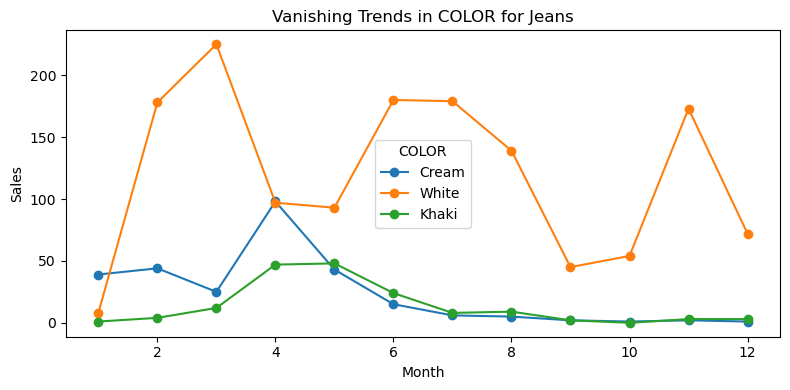

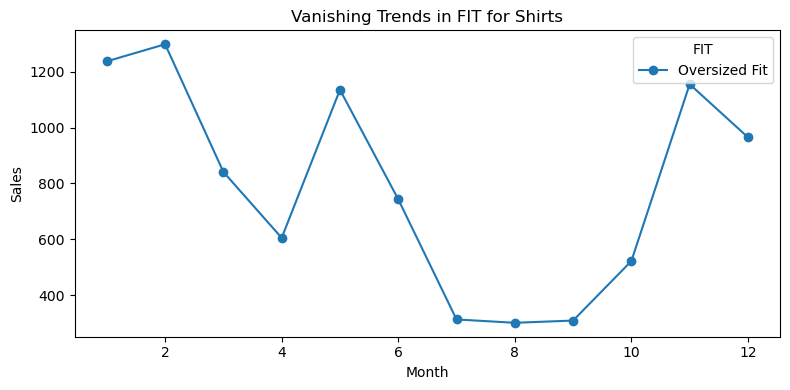

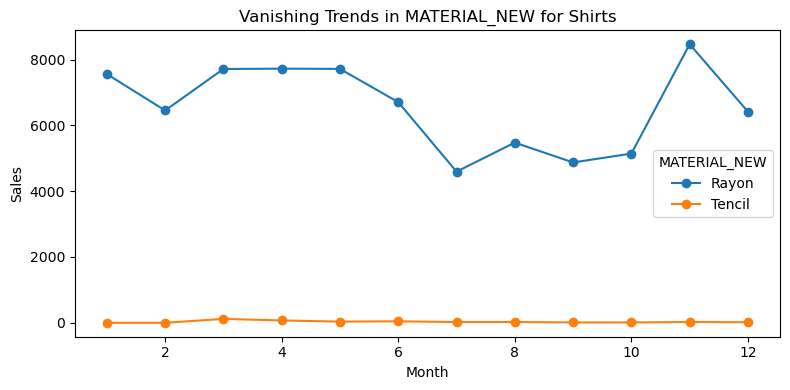

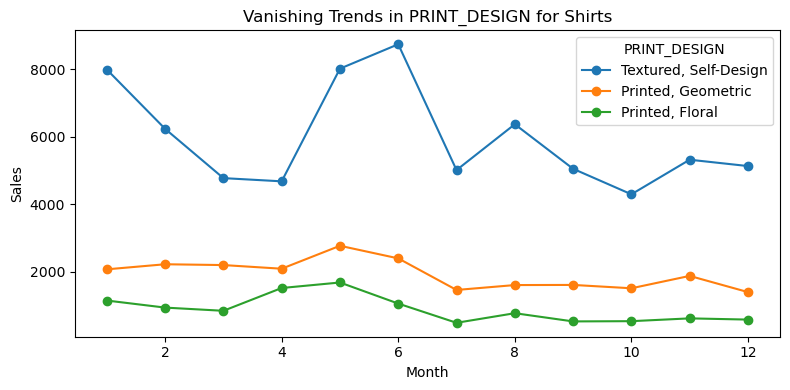

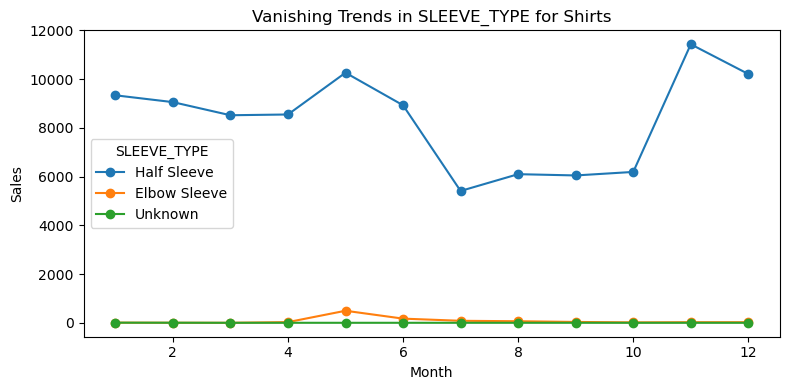

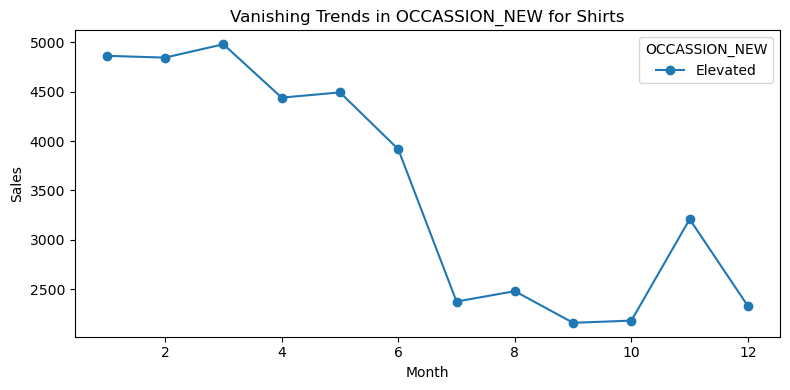

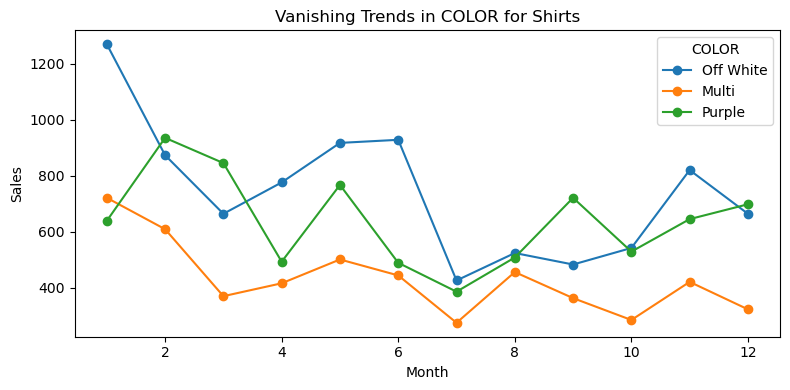

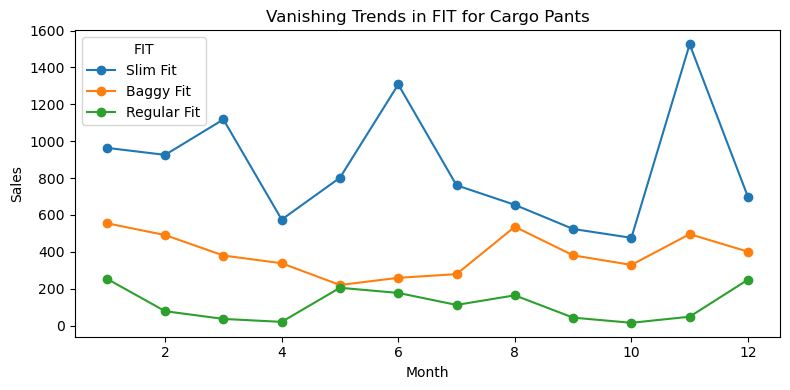

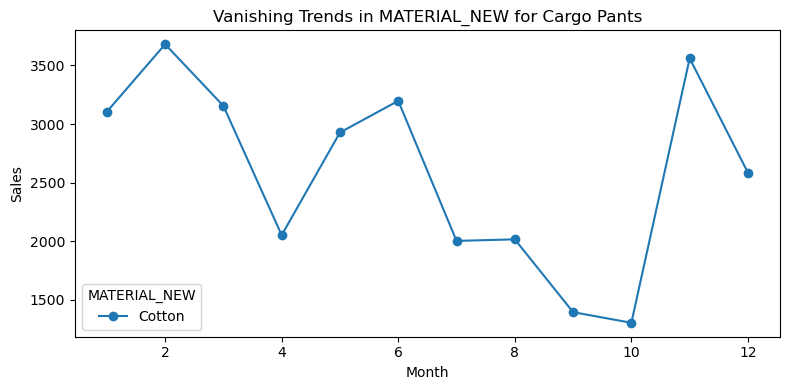

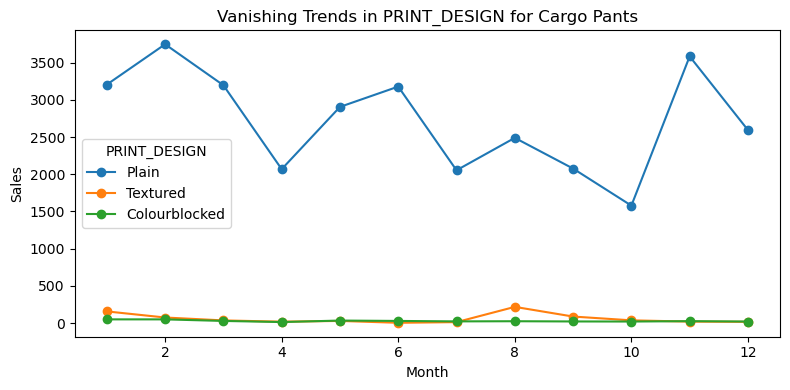

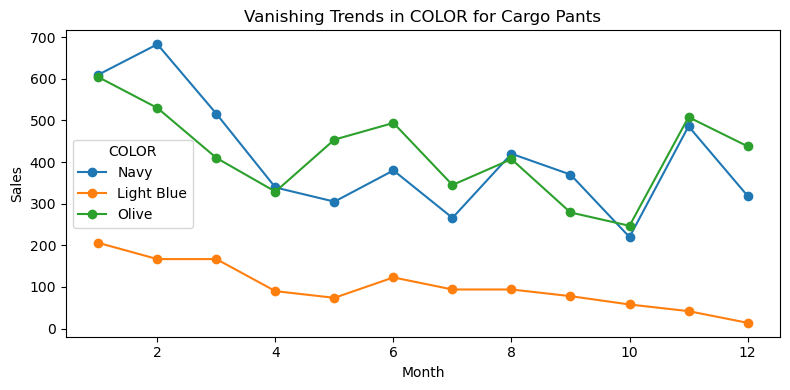

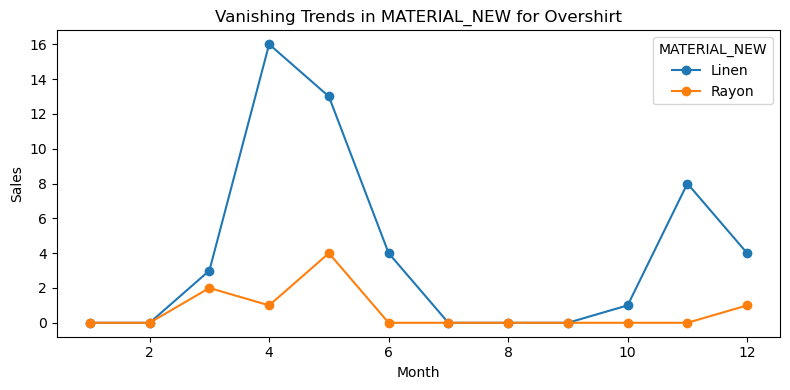

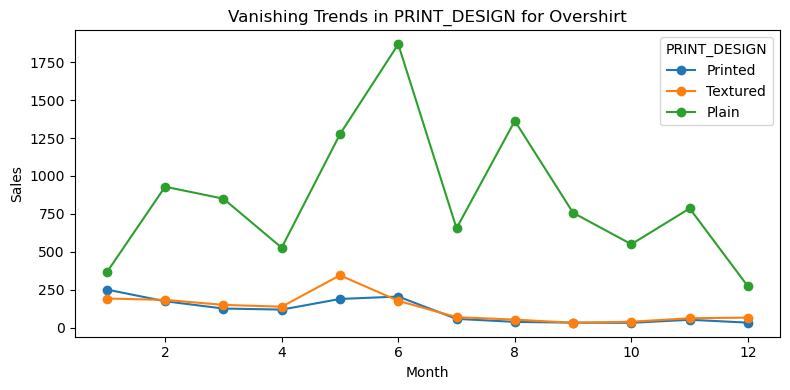

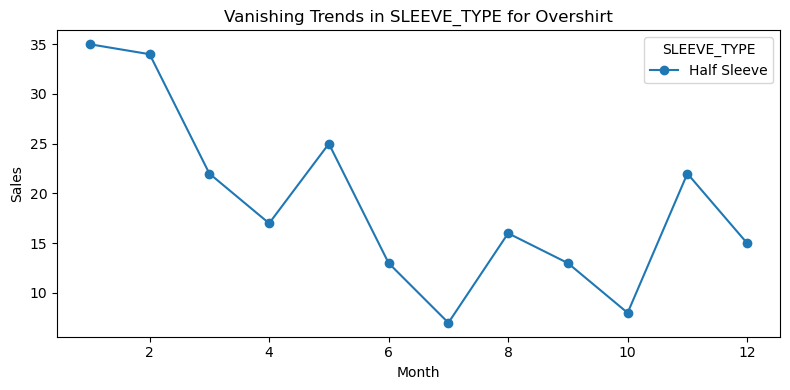

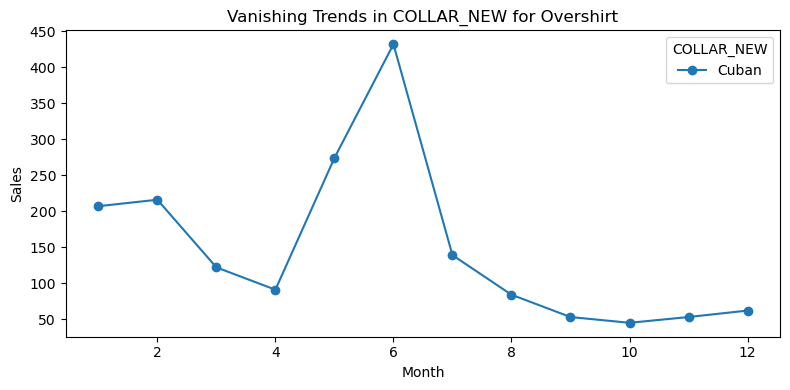

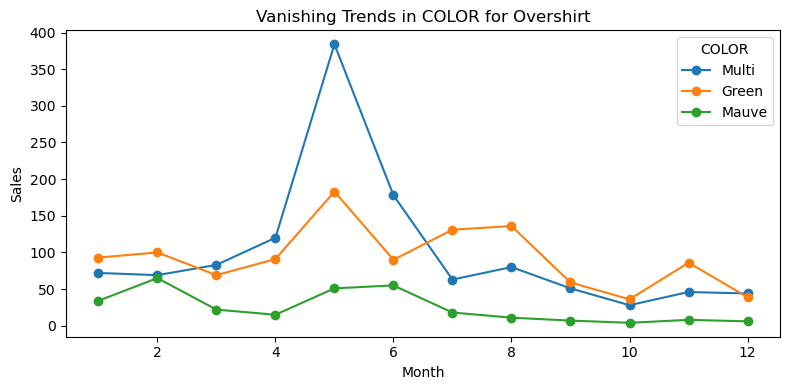

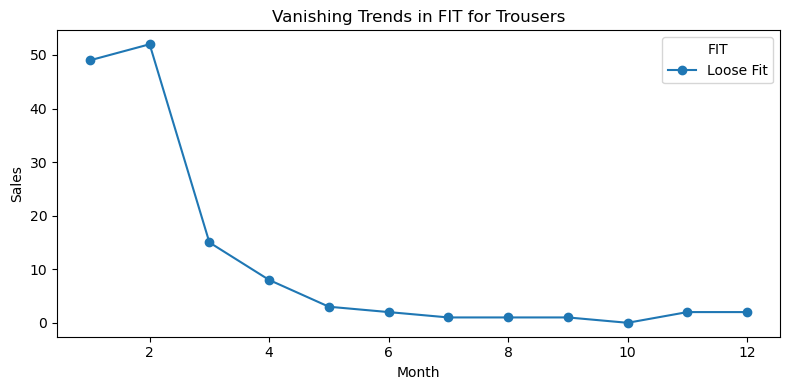

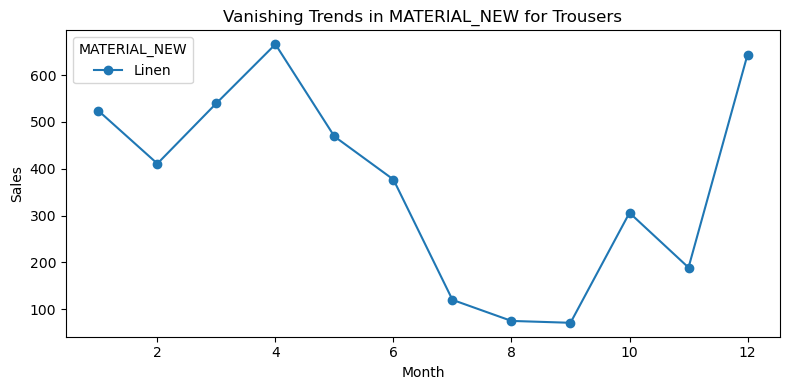

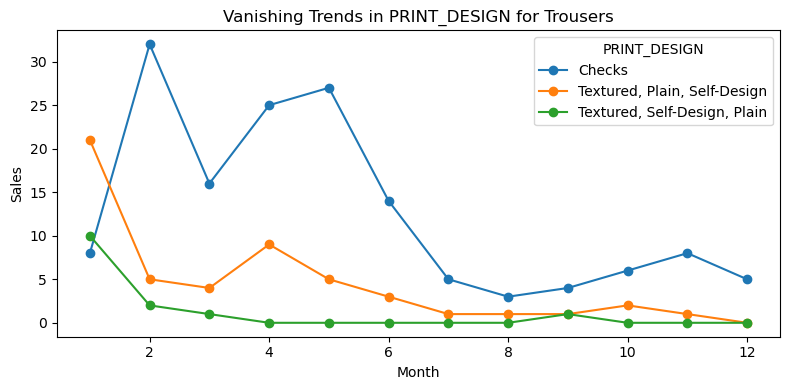

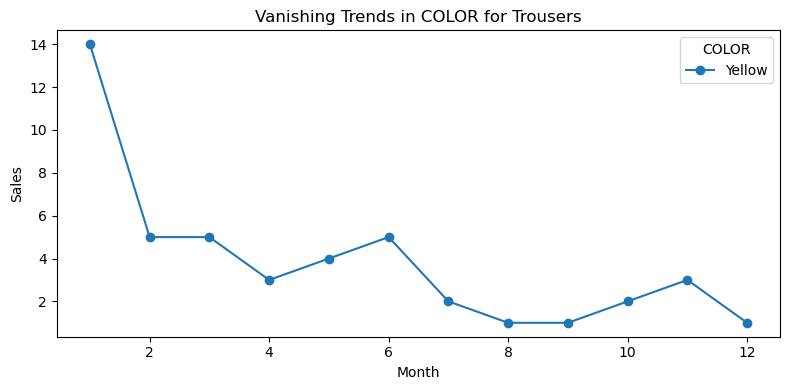

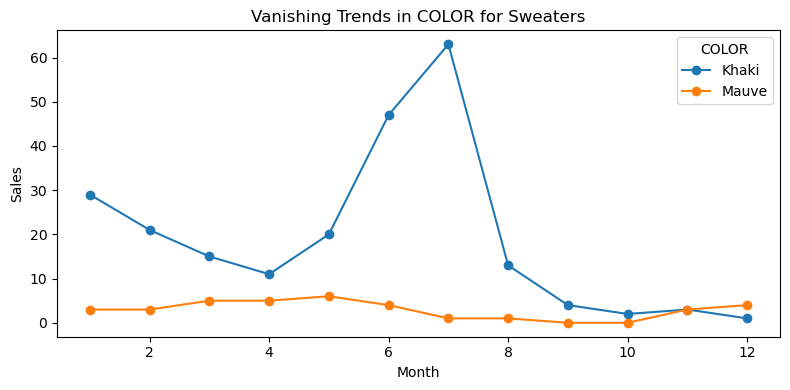

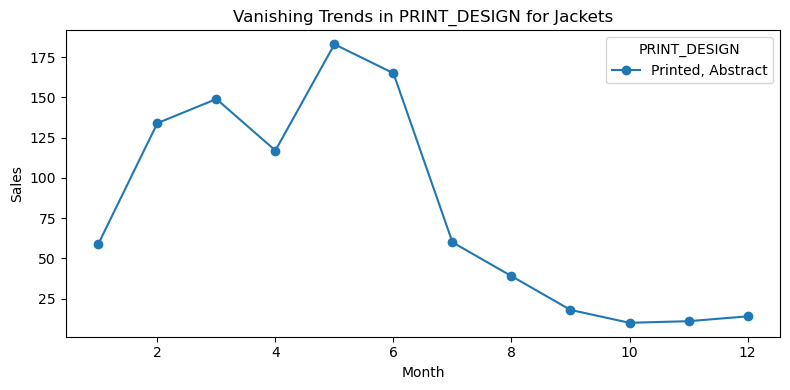

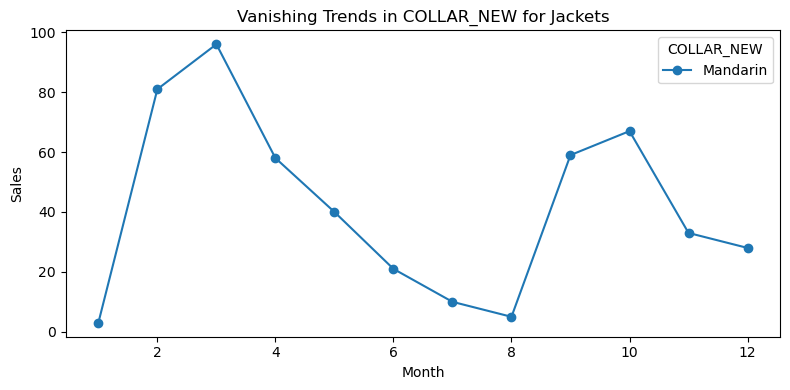

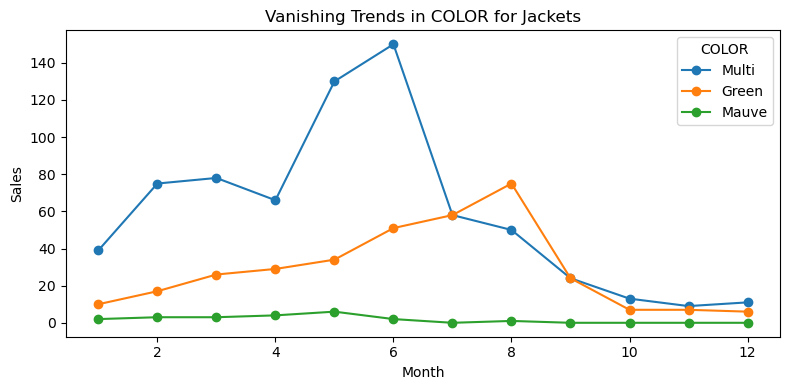

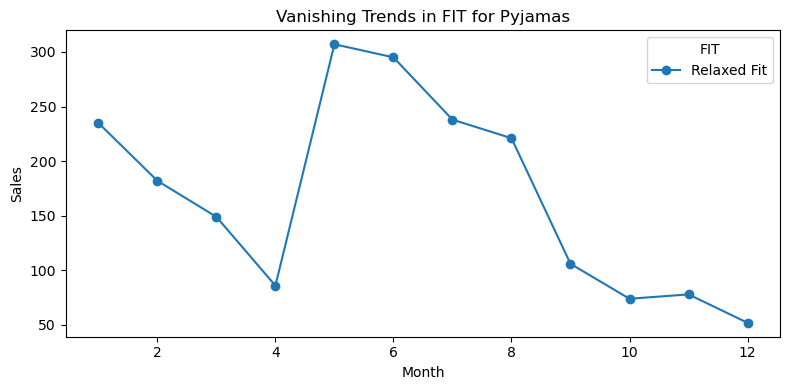

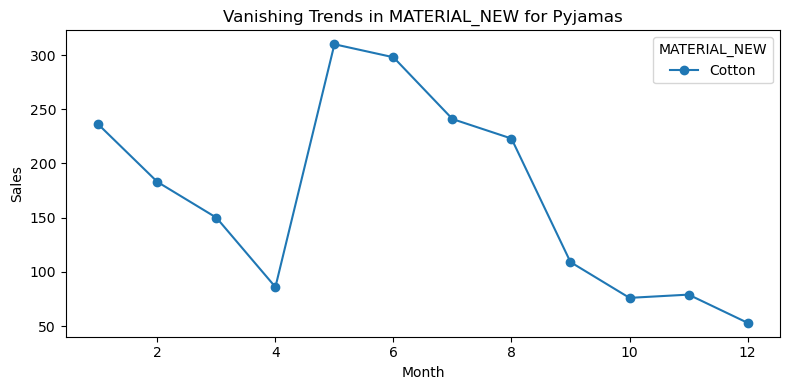

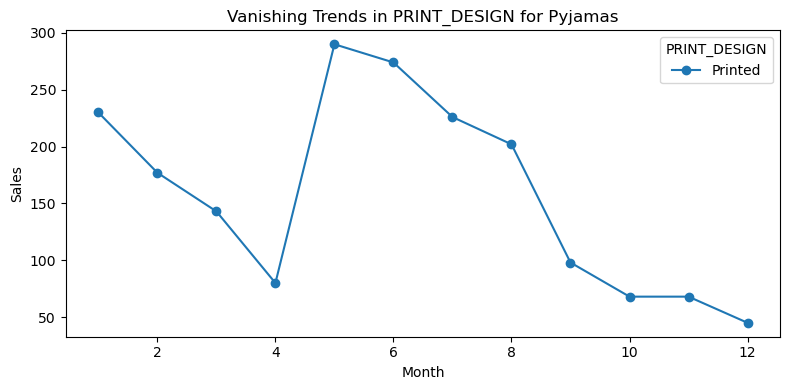

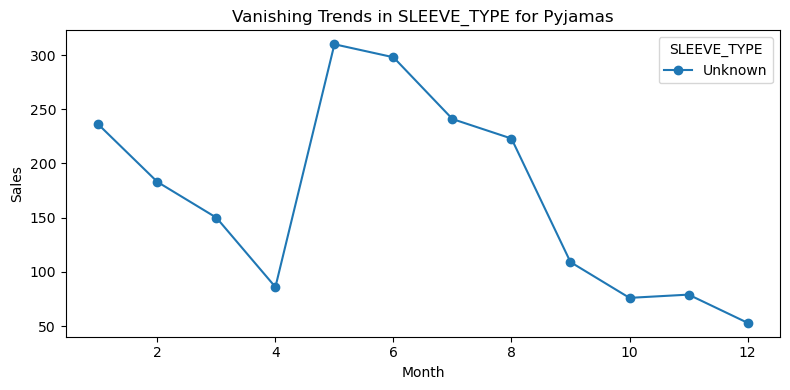

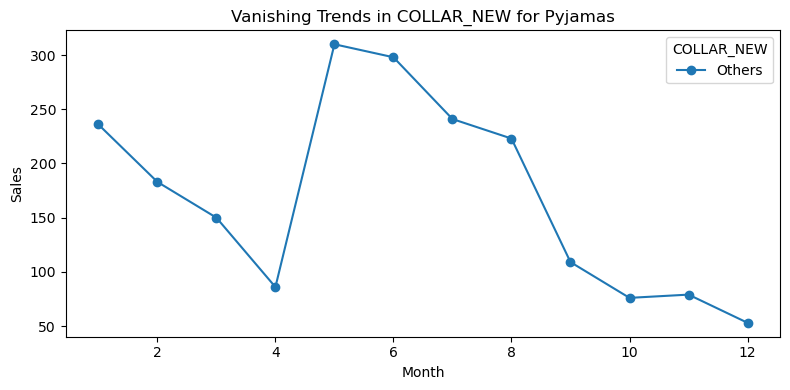

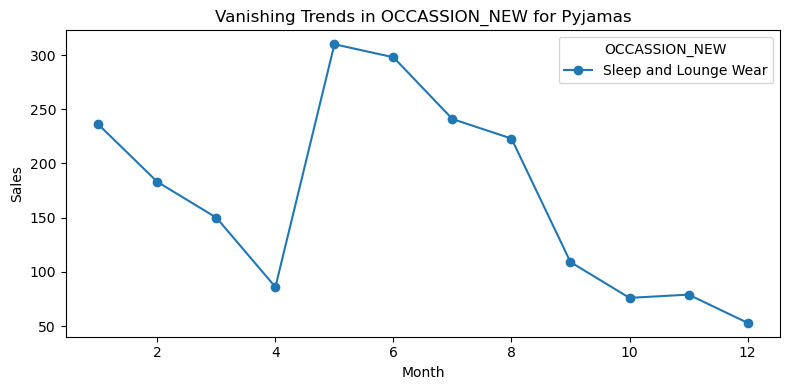

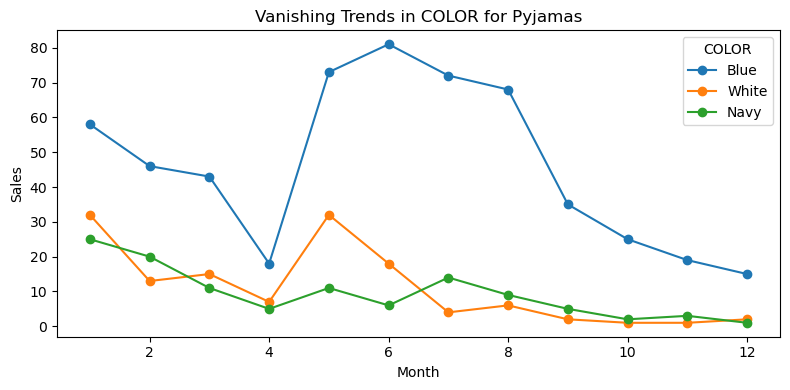

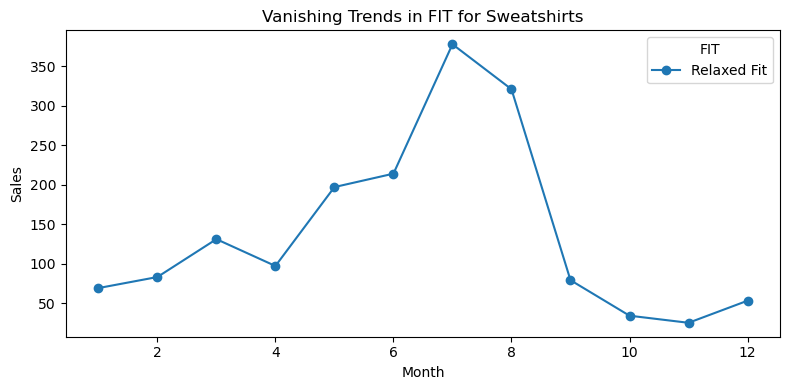

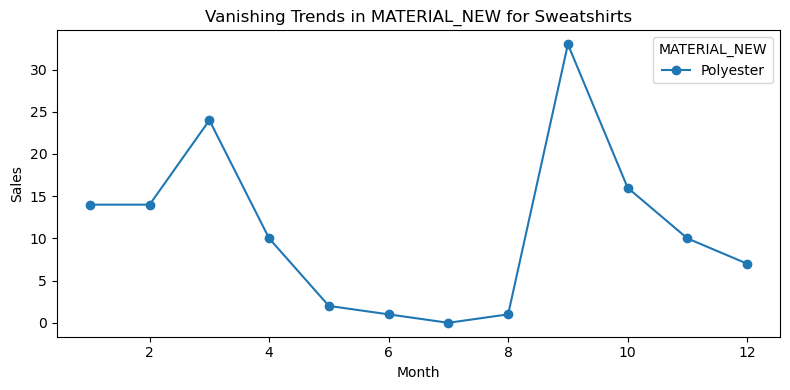

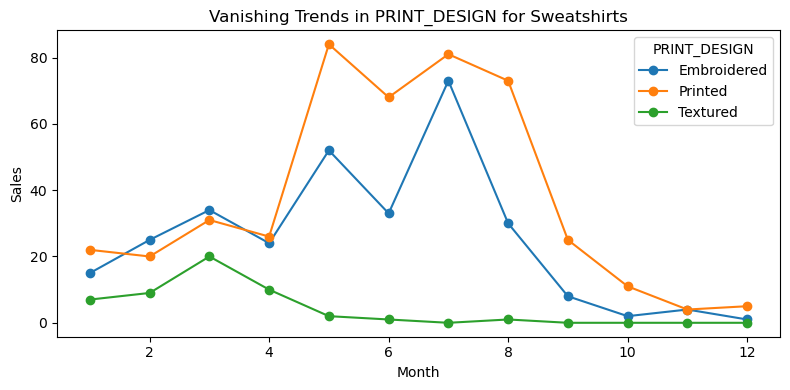

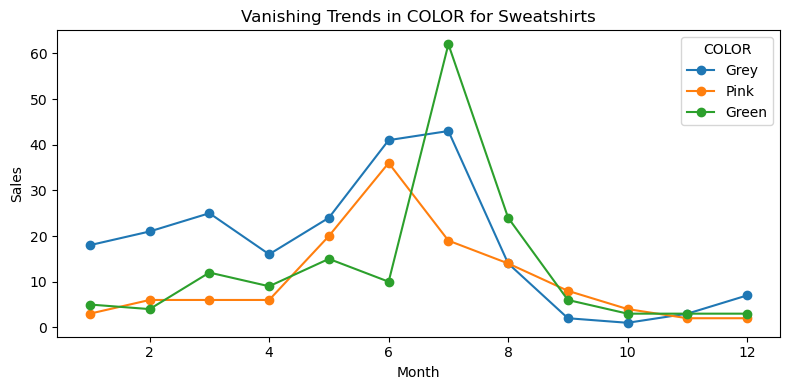

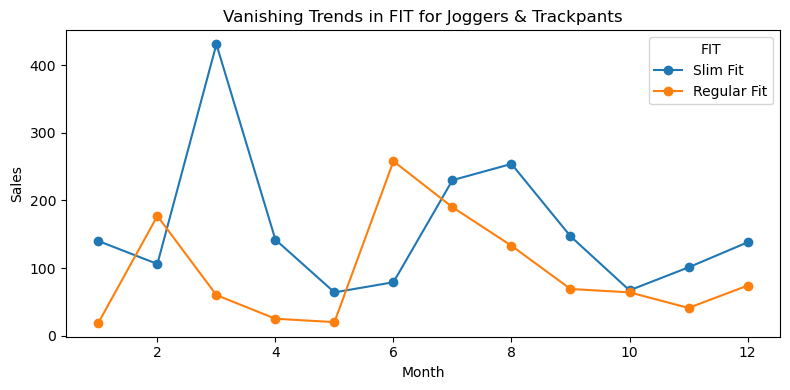

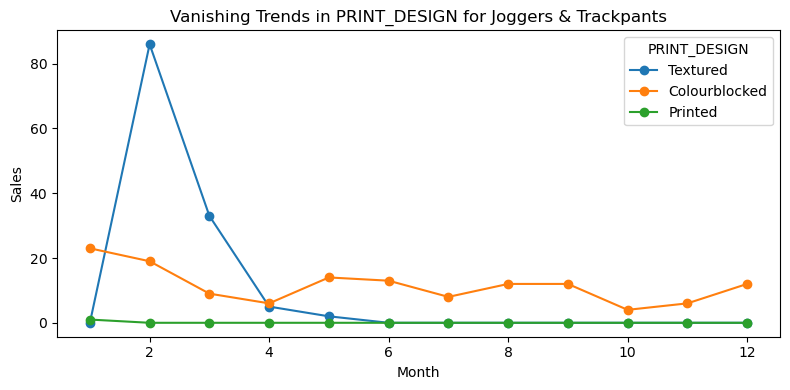

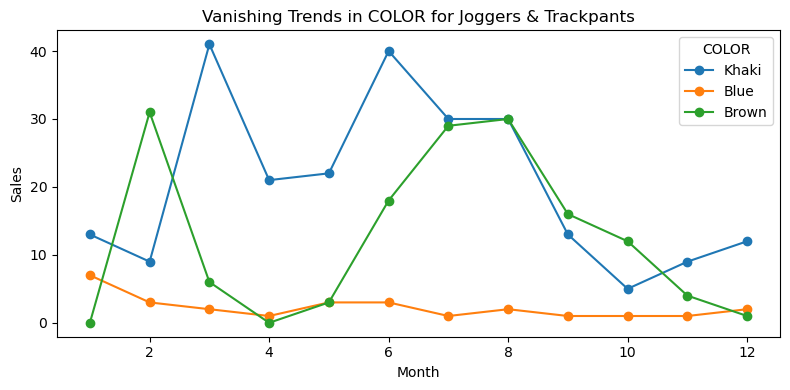

In [ ]:
# Melt to long format for time series
df_long = df.melt(
    id_vars=['CATEGORY'] + feature_columns,
    value_vars=month_cols,
    var_name='MONTH',
    value_name='SALES'
)
df_long['MONTH_NUM'] = df_long['MONTH'].str.extract('(\d+)').astype(int)

# For each category and feature, finding and plotting top 3 vanishing feature values (most negative sales slope)
for category in df_long['CATEGORY'].unique():
    cat_df = df_long[df_long['CATEGORY'] == category]
    for feature in feature_columns:
        pivot = cat_df.groupby([feature, 'MONTH_NUM'])['SALES'].sum().reset_index()
        slopes = {}
        for val in pivot[feature].unique():
            sales_series = pivot[pivot[feature] == val].sort_values('MONTH_NUM')
            if len(sales_series) > 1:
                x = sales_series['MONTH_NUM'].values
                y = sales_series['SALES'].values
                slope = np.polyfit(x, y, 1)[0]
                slopes[val] = slope
        # Get top 3 most negative slopes (vanishing trends)
        vanishing = sorted(slopes.items(), key=lambda x: x[1])[:3]
        vanishing = [v for v in vanishing if v[1] < 0]
        if vanishing:
            # Visualization only — removed all print statements
            plt.figure(figsize=(8,4))
            for val, _ in vanishing:
                sales = pivot[pivot[feature] == val].sort_values('MONTH_NUM')
                plt.plot(sales['MONTH_NUM'], sales['SALES'], marker='o', label=val)
            plt.title(f"Vanishing Trends in {feature} for {category}")
            plt.xlabel('Month')
            plt.ylabel('Sales')
            plt.legend(title=feature)
            plt.tight_layout()
            plt.show()

**Q4.Provide composition on category and feature level (important features determined in the first question) for example if Fit is identified as a crucial feature for Shirts then what will be composition of different materials that should be produced next for example Oversized 70% and Regular 30% for Shirts.**

**Approach ->** For each category, the top 3 significant features (previously identified via importance metrics) were selected to analyze sales composition. Feature values contributing less than 5% of total sales were excluded to eliminate noise and emphasize major contributors. The relative percentage share of each qualifying feature value was computed and visualized through pie charts to inform production prioritization based on dominant sales contributors.


 Production Composition for Shirts:


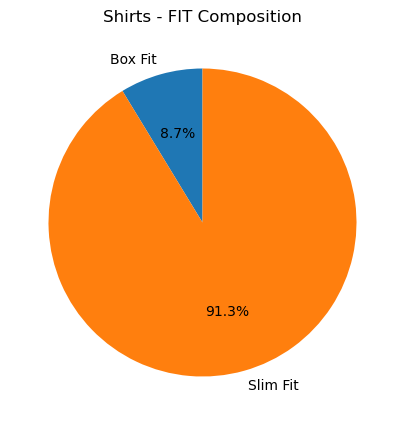

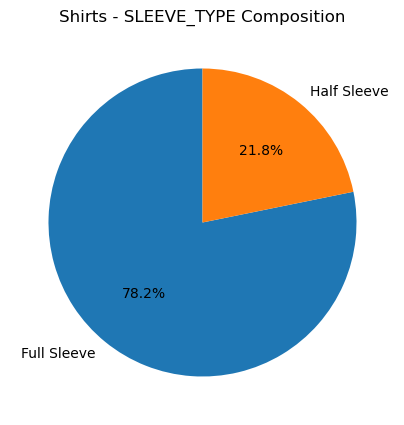

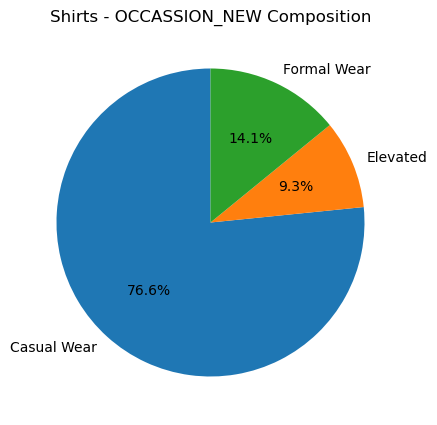


 Production Composition for T-Shirts:


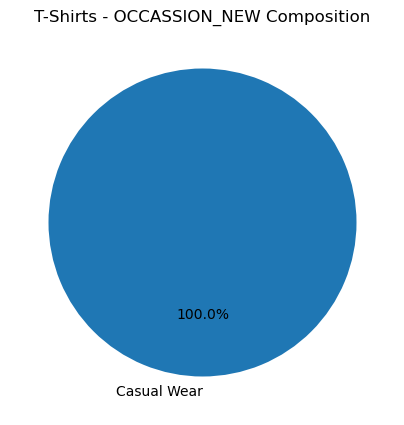

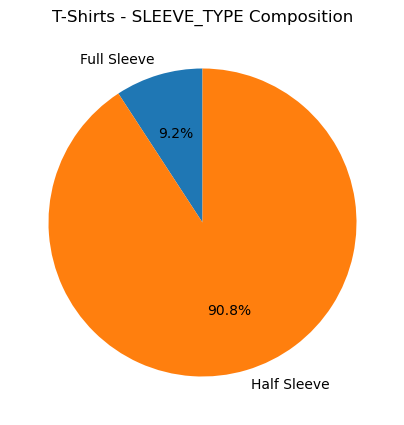

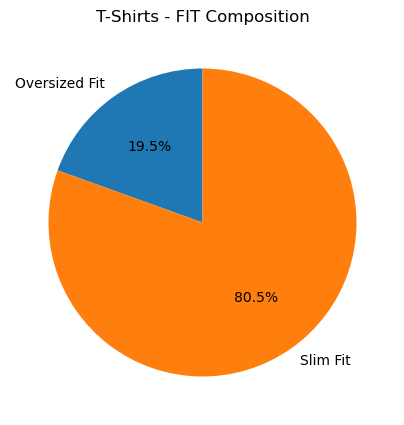


 Production Composition for Jeans:


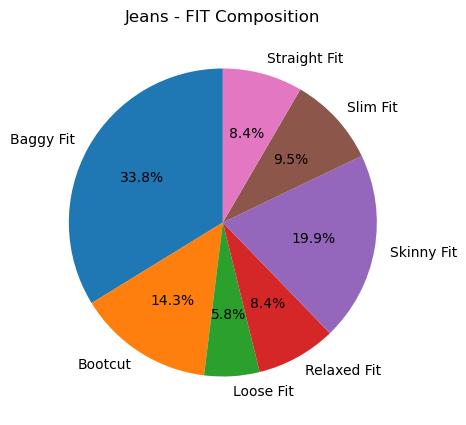

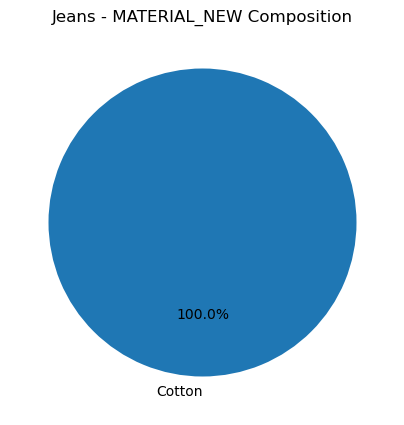

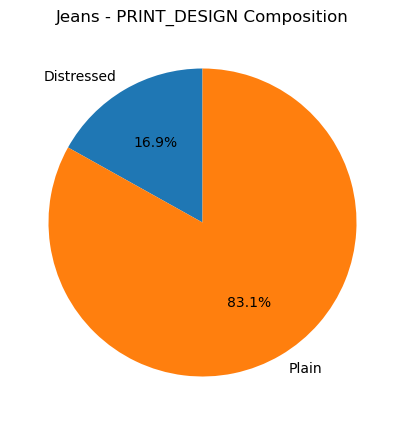


 Production Composition for Trousers:


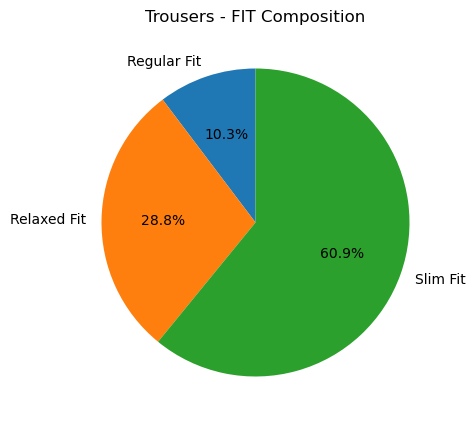

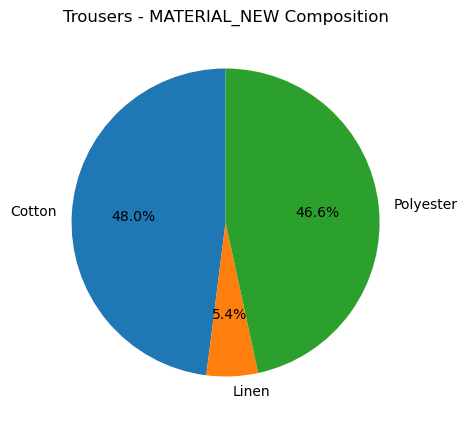

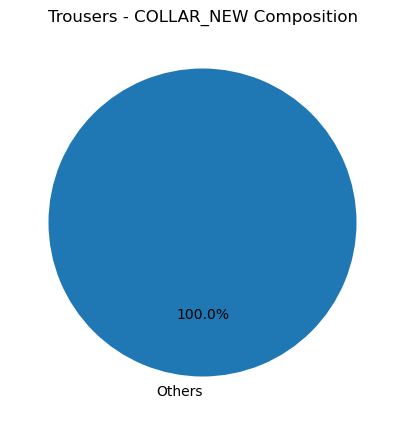


 Production Composition for Jackets:


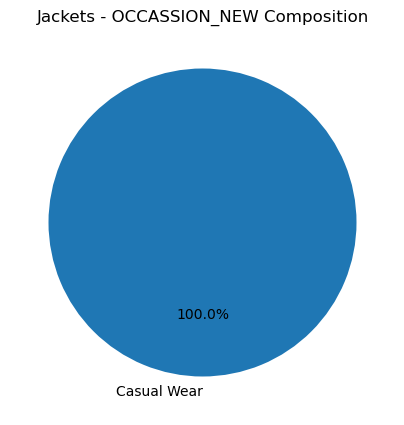

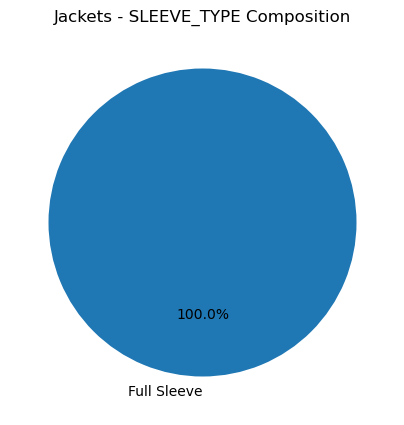

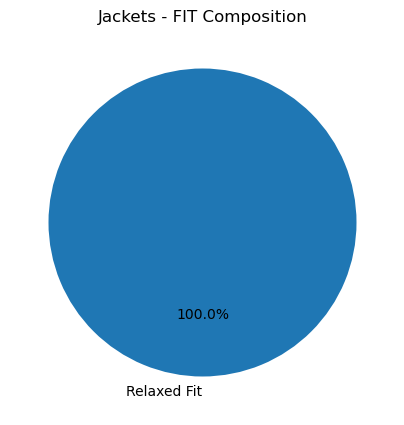


 Production Composition for Sweaters:


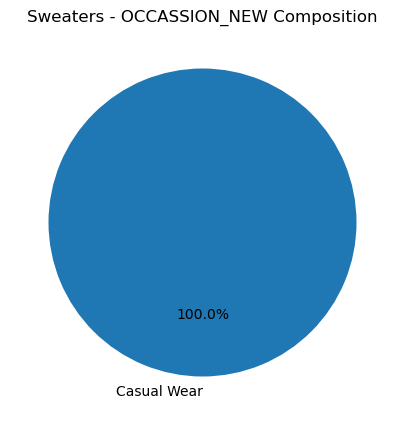

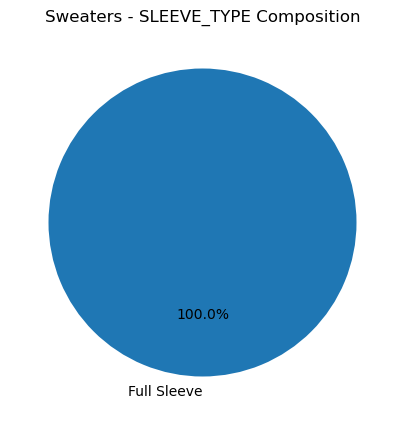

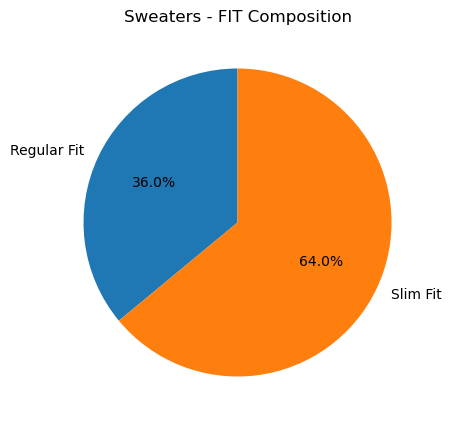


 Production Composition for Overshirt:


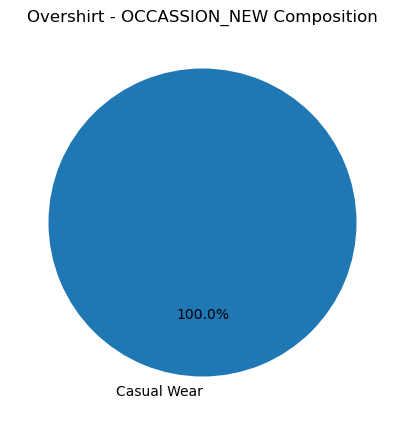

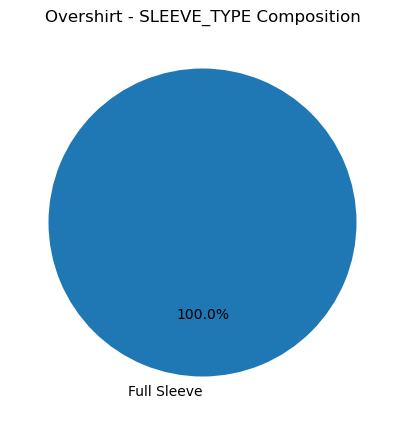

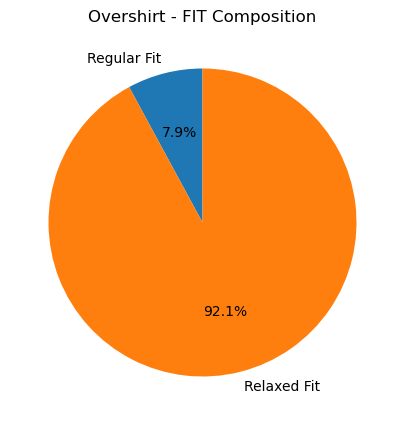

In [ ]:
# Get top 3 features per category from previous analysis
# (Replacing this with our actual feature importance results)
category_top_features = {
    'Shirts': ['FIT', 'SLEEVE_TYPE', 'OCCASSION_NEW'],
    'T-Shirts': ['OCCASSION_NEW', 'SLEEVE_TYPE', 'FIT'],
    'Jeans': ['FIT', 'MATERIAL_NEW', 'PRINT_DESIGN'],
    'Trousers': ['FIT', 'MATERIAL_NEW', 'COLLAR_NEW'],
    'Jackets': ['OCCASSION_NEW', 'SLEEVE_TYPE','FIT'],
    'Sweaters': ['OCCASSION_NEW', 'SLEEVE_TYPE','FIT'],
    'Overshirt': ['OCCASSION_NEW', 'SLEEVE_TYPE','FIT']
}

def calculate_composition(category, features):
    cat_df = df[df['CATEGORY'] == category]
    compositions = {}

    for feature in features:
        # Calculate sales distribution
        feature_dist = cat_df.groupby(feature)['TOTAL_SALES'].sum().reset_index()
        total_sales = feature_dist['TOTAL_SALES'].sum()

        # Calculate percentages and filter out insignificant values (<5%)
        feature_dist['PERCENTAGE'] = (feature_dist['TOTAL_SALES'] / total_sales * 100).round(1)
        feature_dist = feature_dist[feature_dist['PERCENTAGE'] >= 5]

        # Normalize to 100%
        total_percentage = feature_dist['PERCENTAGE'].sum()
        feature_dist['PERCENTAGE'] = (feature_dist['PERCENTAGE'] / total_percentage * 100).round(1)

        compositions[feature] = feature_dist.set_index(feature)['PERCENTAGE'].to_dict()

    return compositions

# Generate and display compositions for all categories
for category, features in category_top_features.items():
    print(f"\n Production Composition for {category}:")
    composition = calculate_composition(category, features)

    for feature, values in composition.items():


        # Pie chart visualization
        plt.figure(figsize=(5,5))
        plt.pie(values.values(), labels=values.keys(), autopct='%1.1f%%', startangle=90)
        plt.title(f"{category} - {feature} Composition")
        plt.show()